# Microsoft Foundry Vision Fine-tuning PoC

## 0. ユースケース: 画像の欠陥検出（画像多値分類タスク）

熱間圧延鋼板の表面欠陥には、圧延スケール（RS）、パッチ（Pa）、クレージング（Cr）、ピット表面（PS）、インクルージョン（In）、スクラッチ（Sc）の6種類がある。データセットには1,800枚のグレースケール画像が含まれており、各欠陥ごとに約300枚（約240枚がトレーニング用、約60枚がテスト用）に分かれている。

**データセット:**
- [NEU Surface Defect Database (Kaggle)](https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database)

<img src="picture\neu.png">

### 参考: ファインチューニングとは

Azure OpenAI Service（現: Microsoft Foundry Models）では、ファインチューニングを通じて特定のデータセットに合わせてモデルをカスタマイズできる。

**ファインチューニングの主なメリット:**
- ✅ プロンプトエンジニアリングだけの場合よりも高品質な結果
- ✅ モデルの最大コンテキスト制限を超える例でトレーニング可能
- ✅ より短いプロンプトによるトークン節約とコスト削減
- ✅ 特に小さなモデルでの低遅延リクエスト

**LoRA（Low-Rank Adaptation）による効率的なファインチューニング:**

LoRAは元の高ランク行列を低ランクのもので近似し、重要なパラメータの小さなサブセットのみをファインチューニングする手法。これにより、モデルはより管理しやすく効率的になり、ユーザーにとってより迅速で手頃なトレーニングを提供する。

> **📖 ドキュメント:** [Azure OpenAI Fine-tuning Guide](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning)

### 参考: ファインチューニング可能なモデルとリージョン

**2025年12月3日時点の Vision ファインチューニング対応モデル:**

| モデル | リージョン | Vision対応 | 備考 |
|--------|-----------|------------|------|
| gpt-4o (2024-08-06) | East US2, North Central US, Sweden Central | ✅ | テキスト＋画像 → テキスト |
| gpt-4o-mini (2024-07-18) | North Central US, Sweden Central | ❌ | テキストのみ |
| gpt-4.1 (2025-04-14) | North Central US, Sweden Central | ✅ | テキスト＋画像 → テキスト |
| gpt-4.1-mini (2025-04-14) | North Central US, Sweden Central | ❌ | テキストのみ |
| gpt-4.1-nano (2025-04-14) | North Central US, Sweden Central | ❌ | テキストのみ |
| o4-mini (2025-04-16) | East US2, Sweden Central | ❌ | 推論モデル（RFT対応） |

> **📖 引用:** [Fine-tuning models - Microsoft Learn](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#fine-tuning-models)

### 参考: ファインチューニングの価格について

**トレーニングティア（2025年12月時点）:**

| ティア | 説明 | 特徴 |
|--------|------|------|
| Standard | 専用キャパシティ | 予測可能なパフォーマンスとSLA、本番ワークロード向け |
| Global Standard | グローバル分散 | より手頃な価格、データレジデンシーなし |
| Developer | アイドルキャパシティ使用 | コスト効率重視、実験・探索向け（ジョブが中断される可能性あり） |

**注意事項:**
- モデルホスティングにも時間単位の費用が発生
- 15日間使用されないデプロイメントは自動削除される
- リージョンによって価格が若干変動

> **📖 引用:** [Azure OpenAI Pricing](https://azure.microsoft.com/ja-jp/pricing/details/cognitive-services/openai-service/)

### 参考: 責任あるAIについて

GPT-4o、GPT-4o-mini、GPT-4.1シリーズなどの高度なモデルは、ファインチューニングが可能だが、責任あるAIの課題（有害なコンテンツ、プライバシー問題など）への配慮が必要。

**Microsoftの評価プロセス:**
- 🔒 評価は専用の顧客特定プライベートワークスペースで実施
- 🔒 評価エンドポイントはAzure OpenAIリソースと同じリージョン
- 🔒 トレーニングデータは評価後に保存されない
- 🔒 評価フィルターは事前定義されたしきい値に設定（カスタム変更不可）

**参考リンク:**
- [Cognitive Services - Overview](https://learn.microsoft.com/en-us/legal/cognitive-services/openai/overview)
- [Transparency Note](https://learn.microsoft.com/en-us/legal/cognitive-services/openai/transparency-note)
- [Microsoft Responsible AI](https://www.microsoft.com/ai/responsible-ai)
- [Content Filtering](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/content-filter)

以下に続くセルで検証を実施

## 1 セットアップ

In [2]:
import base64
import json
import os
import sys
import time
from datetime import datetime
from io import BytesIO, StringIO
import shutil

import matplotlib.pyplot as plt
import numpy as np
from openai import OpenAI
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp
import requests
from azure.identity import DefaultAzureCredential
from IPython.display import clear_output, display
from openai import AzureOpenAI
from PIL import Image
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from tenacity import retry, stop_after_attempt, wait_fixed
from tqdm import tqdm
from mimetypes import guess_type
import japanize_matplotlib


%config InlineBackend.figure_format = 'retina'

In [ ]:
sys.version

In [ ]:
now = datetime.now()
today = now.strftime("%Y-%m-%d %H:%M:%S")
print(f"Today is {today}")

In [ ]:
project_name = "steel-surface-defects-gpt41"

In [ ]:
from dotenv import load_dotenv
from sklearn.utils import resample

load_dotenv(override=True)

api_key = os.environ["api_key"]
azure_endpoint = os.environ["azure_endpoint"]
subscription_id = os.environ["subscription_id"]
rg_name = os.environ["rg_name"]
resource_name: str = os.environ["resource_name"]

# 確認用
print(f"azure_endpoint: {azure_endpoint}")
print(f"resource_name: {resource_name}")

In [ ]:
client = OpenAI(
    api_key=api_key,
    base_url=azure_endpoint,
)

## 2 ヘルパー関数

In [ ]:
from collections import Counter
from pathlib import Path
from typing import Iterator

# 画像関連の定数
IMAGE_EXTENSIONS: frozenset[str] = frozenset({".jpg", ".jpeg", ".png", ".webp", ".gif", ".bmp"})
SKIP_DIRS: frozenset[str] = frozenset({".ipynb_checkpoints", "__pycache__", ".git"})

# 型エイリアス
PathLike = str | os.PathLike[str]


def _ensure_directory(path: PathLike) -> Path:
    """パスがディレクトリであることを検証し、Pathオブジェクトを返す。"""
    directory = Path(path).expanduser().resolve()
    if not directory.exists():
        raise FileNotFoundError(f"ディレクトリが見つかりません: {directory}")
    if not directory.is_dir():
        raise NotADirectoryError(f"ディレクトリを指定してください: {directory}")
    return directory


def _iter_image_files(root: Path, *, recursive: bool = True) -> Iterator[Path]:
    """指定ディレクトリ配下の画像ファイルをイテレートする。"""
    if recursive:
        for current_root, dirs, files in os.walk(root):
            dirs[:] = [d for d in dirs if d not in SKIP_DIRS]
            current_path = Path(current_root)
            for name in sorted(files):  # 順序を安定させる
                candidate = current_path / name
                if candidate.suffix.lower() in IMAGE_EXTENSIONS:
                    yield candidate
    else:
        for candidate in sorted(root.iterdir()):
            if candidate.is_file() and candidate.suffix.lower() in IMAGE_EXTENSIONS:
                yield candidate


def count_image_files(path: PathLike, *, verbose: bool = True) -> int:
    """グローバルおよびディレクトリ別の画像枚数を集計する。"""
    root = _ensure_directory(path)
    counts: Counter[Path] = Counter(img.parent for img in _iter_image_files(root))
    if verbose and counts:
        for directory, count in sorted(counts.items()):
            print(f"{directory.relative_to(root.parent)} | 画像ファイルの数 = {count}")
    return counts.total()


def display_image(image_file: PathLike) -> Image.Image | None:
    """画像を表示し、見つからない場合はNoneを返す。"""
    path = Path(image_file)
    if not path.exists():
        print(f"[エラー] 画像ファイル {path} は存在しません")
        return None
    print(f"分類する画像ファイル: {path.name}")
    with Image.open(path) as img:
        img.load()  # 遅延読み込みを完了
        display(img)
        return img.copy()


def local_image_to_data_url(image_file: PathLike) -> str | None:
    """ローカル画像を data URL (base64) に変換する。"""
    path = Path(image_file)
    if not path.exists():
        print(f"[エラー] 画像ファイル {path} は存在しません")
        return None
    mime_type = guess_type(path.name)[0] or "application/octet-stream"
    encoded = base64.b64encode(path.read_bytes()).decode("utf-8")
    return f"data:{mime_type};base64,{encoded}"


# 後方互換性のためのエイリアス
local_image_to_url = local_image_to_data_url


def get_images_info(directory: PathLike) -> pd.DataFrame:
    """画像のパス・ファイルサイズ・解像度を DataFrame で返す。"""
    root = _ensure_directory(directory)
    records: list[dict[str, object]] = []
    for image_path in _iter_image_files(root):
        with Image.open(image_path) as img:
            width, height = img.size
        records.append(
            {
                "image_file": str(image_path),
                "size_in_bytes": image_path.stat().st_size,
                "image_width": width,
                "image_height": height,
            }
        )
    return pd.DataFrame(records).sort_values("image_file", ignore_index=True)

In [ ]:
from typing import Any, NamedTuple

# デフォルト設定
DEFAULT_IMAGE_QUALITY = 100
DEFAULT_WINDOW_SIZE = 5
DEFAULT_EVENT_LIMIT = 10
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"


# ANSIエスケープコード（ターミナル装飾用）
class AnsiStyle:
    """ターミナル出力用のANSIスタイル定数。"""

    BOLD = "\033[1m"
    RESET = "\033[0m"
    BLUE = "\033[34m"
    GREEN = "\033[32m"
    RED = "\033[31m"


class FineTuningJobInfo(NamedTuple):
    """ファインチューニングジョブの情報を保持する型。"""

    job_id: str
    status: str
    raw_json: str


def encode_image(image: Image.Image, quality: int = DEFAULT_IMAGE_QUALITY) -> str:
    """
    PIL画像をJPEGに変換してbase64文字列として返す。

    Args:
        image: エンコードするPIL画像
        quality: JPEG品質 (1-100)

    Returns:
        base64エンコードされた画像文字列
    """
    if image.mode != "RGB":
        image = image.convert("RGB")
    buffered = BytesIO()
    image.save(buffered, format="JPEG", quality=quality)
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def date_sorted_df(details_dict: dict[str, Any]) -> pd.DataFrame:
    """
    ジョブ詳細の辞書を日付順に並んだDataFrameへ整形する。

    Args:
        details_dict: APIレスポンスから取得した辞書データ

    Returns:
        日付降順でソートされたDataFrame
    """
    df = pd.DataFrame(details_dict)
    if df.empty:
        return df

    # 列名の正規化
    if "created" in df.columns:
        df = df.rename(columns={"created": "created_at"})

    # タイムスタンプを読みやすい形式に変換
    timestamp_columns = ["created_at", "finished_at"]
    for column in timestamp_columns:
        if column in df.columns:
            df[column] = pd.to_datetime(df[column], unit="s", errors="coerce").dt.strftime(
                DATE_FORMAT
            )

    return df.sort_values(by="created_at", ascending=False, na_position="last").reset_index(
        drop=True
    )


def _compute_smoothed_metrics(
    df: pd.DataFrame, window: int
) -> tuple[pd.DataFrame, pd.DataFrame | None]:
    """
    トレーニングと検証メトリクスをスムージングする。

    Args:
        df: メトリクスを含むDataFrame
        window: スムージングウィンドウサイズ

    Returns:
        (スムージングされた全データ, スムージングされた検証データ or None)
    """
    smooth_df = df.rolling(window=window, min_periods=1).mean(numeric_only=True)

    # 有効な検証データのみ抽出
    valid_mask = df["valid_loss"].notna() & (df["valid_loss"] != -1.0)
    valid_df = df.loc[valid_mask].reset_index(drop=True)

    if valid_df.empty:
        return smooth_df, None

    valid_window = max(1, min(window, len(valid_df)))
    valid_smooth = valid_df.rolling(window=valid_window, min_periods=1).mean(numeric_only=True)
    return smooth_df, (valid_df, valid_smooth)


def show_ft_metrics(results_df: pd.DataFrame, window_size: int = DEFAULT_WINDOW_SIZE) -> None:
    """
    トレーニング/検証メトリクスをスムージングして可視化する。

    Args:
        results_df: ファインチューニング結果のDataFrame
        window_size: スムージングウィンドウサイズ

    Raises:
        ValueError: データが空または必須列が不足している場合
    """
    if results_df.empty:
        raise ValueError("メトリクスを描画するデータがありません。")

    required_columns = frozenset(
        {
            "step",
            "train_loss",
            "train_mean_token_accuracy",
            "valid_loss",
            "valid_mean_token_accuracy",
        }
    )
    missing = required_columns - set(results_df.columns)
    if missing:
        raise ValueError(f"不足している列があります: {', '.join(sorted(missing))}")

    sorted_df = results_df.sort_values("step").reset_index(drop=True)
    window = max(1, min(window_size, len(sorted_df)))
    smooth_df, valid_result = _compute_smoothed_metrics(sorted_df, window)

    # サブプロットの作成
    fig = sp.make_subplots(
        rows=2,
        cols=2,
        subplot_titles=(
            "Train Loss",
            "Train Mean Token Accuracy",
            "Validation Loss",
            "Validation Mean Token Accuracy",
        ),
    )

    # トレーニングメトリクス
    fig.add_trace(
        go.Scatter(
            x=sorted_df["step"],
            y=smooth_df["train_loss"],
            mode="lines",
            name="Train Loss",
            line={"color": "blue"},
        ),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=sorted_df["step"],
            y=smooth_df["train_mean_token_accuracy"],
            mode="lines",
            name="Train Mean Token Accuracy",
            line={"color": "green"},
        ),
        row=1,
        col=2,
    )

    # 検証メトリクス（存在する場合）
    if valid_result is not None:
        valid_df, valid_smooth = valid_result
        fig.add_trace(
            go.Scatter(
                x=valid_df["step"],
                y=valid_smooth["valid_loss"],
                mode="lines",
                name="Validation Loss",
                line={"color": "orange"},
            ),
            row=2,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=valid_df["step"],
                y=valid_smooth["valid_mean_token_accuracy"],
                mode="lines",
                name="Validation Mean Token Accuracy",
                line={"color": "red"},
            ),
            row=2,
            col=2,
        )

    fig.update_layout(
        height=700,
        width=1000,
        legend_title_text="Metric",
        title="Fine-tuning metrics",
        hovermode="x unified",
        showlegend=True,
    )
    # VS Code Notebook 用に plotly_mimetype レンダラーを使用
    import plotly.io as pio

    pio.renderers.default = "plotly_mimetype+notebook"
    fig.show()


def _print_timestamp(style: str = "\033[34m") -> None:
    """現在時刻をスタイル付きで出力する。"""
    timestamp = datetime.now().strftime(DATE_FORMAT)
    print(f"{AnsiStyle.BOLD}{style}{timestamp}{AnsiStyle.RESET}")


def get_ft_job_definition(ft_job: Any) -> dict[str, Any]:
    """
    ファインチューニングジョブの定義を表示する。

    Args:
        ft_job: ファインチューニングジョブオブジェクト

    Returns:
        ファインチューニングジョブの定義辞書
    """
    job_dict = ft_job.to_dict()
    print(f"{AnsiStyle.BOLD}{AnsiStyle.BLUE}")
    print(json.dumps(job_dict, indent=2, ensure_ascii=False, default=str))
    print(AnsiStyle.RESET)
    return job_dict


def get_ft_status(client: OpenAI, job_id: str) -> str:
    """
    最新のファインチューニングジョブのステータスを取得し、表示する。

    Args:
        client: OpenAIクライアントインスタンス
        job_id: ステータスを取得するファインチューニングジョブのID

    Returns:
        最新のファインチューニングジョブのステータス
    """
    _print_timestamp()
    response = client.fine_tuning.jobs.retrieve(job_id)
    status = response.status
    print(f"Job status of {job_id}: {status}")
    return status


def get_ft_list_of_events(client: OpenAI, job_id: str, *, limit: int = DEFAULT_EVENT_LIMIT) -> str:
    """
    特定のファインチューニングジョブのイベントリストをJSON形式で取得して返す。

    Args:
        client: OpenAIクライアントインスタンス
        job_id: イベントを取得するファインチューニングジョブのID
        limit: 取得するイベントの最大数

    Returns:
        指定したファインチューニングジョブのイベントリストを含むJSON形式の文字列
    """
    _print_timestamp()
    response = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=limit)
    events = response.model_dump_json(indent=2)
    print(events)
    return events


def get_ft_job_info(client: OpenAI, job_id: str) -> FineTuningJobInfo:
    """
    特定のファインチューニングジョブについての詳細情報を取得し、表示する。

    Args:
        client: OpenAIクライアントインスタンス
        job_id: 情報を取得するファインチューニングジョブのID

    Returns:
        FineTuningJobInfo: ジョブID、ステータス、生のJSONを含むNamedTuple
    """
    _print_timestamp()
    response = client.fine_tuning.jobs.retrieve(job_id)
    raw_json = response.model_dump_json(indent=2)

    print(f"Job ID: {response.id}")
    print(f"Status: {response.status}")
    print(raw_json)

    return FineTuningJobInfo(job_id=response.id, status=response.status, raw_json=raw_json)

## 3 データセットの取得と準備

画像のファインチューニングは、chat completion APIに画像を入力するプロセスと似たJSONLデータセットファイルで可能。

画像は、以下に示すようにHTTP URLまたはbase64でエンコードされた画像を含むデータURLとして提供できる。

```json
{
  "messages": [
    { "role": "system", "content": "You are an assistant that identifies corporate logos." },
    { "role": "user", "content": "What is this logo?" },
    { "role": "user", "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/fr/thumb/b/b6/Microsoft-Azure.png/100px-Microsoft-Azure.png"
          }
        }
      ]
    },
    { "role": "assistant", "content": "Microsoft Azure" }
  ]
}
```

### 画像データセットの要件

**データセットサイズ:**
| 項目 | 制限 |
|------|------|
| トレーニングファイルの最大例数 | 50,000（画像を含む例のみ） |
| 各例の最大画像数 | 64枚 |
| 各画像の最大サイズ | 10MB |
| ファイルサイズ上限 | 512MB |

**サポートされる画像フォーマット:**
- ✅ JPEG
- ✅ PNG  
- ✅ WEBP

> **注意:** 画像はRGBまたはRGBAの画像モードである必要がある

### 除外される画像

以下を含む画像はデータセットから**自動的に除外**され、トレーニングには使用されない:
- 🚫 人物
- 🚫 顔
- 🚫 CAPTCHA

### トレーニングコストの最適化

画像の`detail`パラメータを`low`に設定すると:
- 画像は512×512ピクセルにリサイズ
- サイズに関係なく**85トークン**で表現
- トレーニングコストを大幅に削減可能

### データセットサイズの推奨事項

- **最小:** 10例（ジョブは開始するが、モデルへの影響は限定的）
- **推奨:** 50例以上の高品質なトレーニングデータ
- **ベストプラクティス:** 数百〜数千の例を用意

> **💡 ヒント:** データセットサイズを2倍にすると、モデル品質が線形的に向上する傾向がある。ただし、低品質な例はパフォーマンスに悪影響を与える可能性があるため、高品質な例のみを選別することが重要。

**参考リンク:**
- [Fine-tuning Guide](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning)
- [Transparency Note](https://learn.microsoft.com/en-us/legal/cognitive-services/openai/transparency-note)

### データセットの準備

In [ ]:
"""
NEU-DET データセットから鋼材表面欠陥画像を分類フォルダへコピーする。

NEU-DET (Northeastern University DEfect daTaset):
- 6種類の鋼材表面欠陥タイプを含むデータセット
- 各クラス約300枚、合計約1,800枚のグレースケール画像
- 画像サイズ: 200×200 ピクセル

📁 出力先フォルダ構造:
    steel_surface_defects/
    ├── class1/  (rolled_in_scale: 圧延スケール)
    ├── class2/  (pitted_surface: ピット状表面)
    ├── class3/  (patches: パッチ状欠陥)
    ├── class4/  (inclusion: 介在物)
    ├── class5/  (crazing: クレージング)
    └── class6/  (scratches: 傷)
"""
from dataclasses import dataclass
from enum import Enum


class DefectType(str, Enum):
    """鋼材表面欠陥タイプの定義（NEU-DET データセット準拠）"""

    ROLLED_IN_SCALE = "rolled_in_scale"  # 圧延スケール
    PITTED_SURFACE = "pitted_surface"  # ピット状表面
    PATCHES = "patches"  # パッチ状欠陥
    INCLUSION = "inclusion"  # 介在物
    CRAZING = "crazing"  # クレージング
    SCRATCHES = "scratches"  # 傷


@dataclass(frozen=True)
class DatasetPaths:
    """データセットのパス設定"""

    source_dir: Path  # NEU-DET ソースディレクトリ
    output_dir: Path  # 出力先ディレクトリ

    @classmethod
    def default(cls) -> "DatasetPaths":
        """デフォルトのパス設定を取得"""
        base_path = Path.cwd()
        return cls(
            source_dir=base_path / "NEU-DET",
            output_dir=base_path / "steel_surface_defects",
        )


# 欠陥タイプ → クラスフォルダ名のマッピング
CLASS_MAPPING: dict[DefectType, str] = {
    DefectType.ROLLED_IN_SCALE: "class1",
    DefectType.PITTED_SURFACE: "class2",
    DefectType.PATCHES: "class3",
    DefectType.INCLUSION: "class4",
    DefectType.CRAZING: "class5",
    DefectType.SCRATCHES: "class6",
}

# サポートする画像拡張子
SUPPORTED_IMAGE_EXTENSIONS: frozenset[str] = frozenset({".png", ".jpg", ".jpeg", ".webp"})


def copy_images_to_class_folders(paths: DatasetPaths | None = None) -> dict[str, int]:
    """
    NEU-DET データセットから画像を分類フォルダへコピーする。

    Args:
        paths: データセットのパス設定（Noneの場合はデフォルト設定を使用）

    Returns:
        各クラスにコピーした画像数の辞書
    """
    if paths is None:
        paths = DatasetPaths.default()

    # 出力先のクラスフォルダを作成
    for folder_name in CLASS_MAPPING.values():
        (paths.output_dir / folder_name).mkdir(parents=True, exist_ok=True)

    copy_counts: dict[str, int] = {folder: 0 for folder in CLASS_MAPPING.values()}

    # train および validation フォルダを処理
    for dataset_type in ("train", "validation"):
        images_dir = paths.source_dir / dataset_type / "images"

        for defect_type, folder_name in CLASS_MAPPING.items():
            class_images_dir = images_dir / defect_type.value

            if not class_images_dir.exists():
                continue

            for image_file in class_images_dir.iterdir():
                if image_file.suffix.lower() in SUPPORTED_IMAGE_EXTENSIONS:
                    destination_file = paths.output_dir / folder_name / image_file.name
                    shutil.copy2(image_file, destination_file)
                    copy_counts[folder_name] += 1

    return copy_counts


# 画像をコピー
copy_result = copy_images_to_class_folders()
print("📊 コピー結果:")
for class_folder, count in copy_result.items():
    defect_label = next(
        (dt.value for dt, cf in CLASS_MAPPING.items() if cf == class_folder), "unknown"
    )
    print(f"  {class_folder} ({defect_label}): {count} 枚")

📊 コピー結果:
  class1 (rolled_in_scale): 300 枚
  class2 (pitted_surface): 300 枚
  class3 (patches): 300 枚
  class4 (inclusion): 300 枚
  class5 (crazing): 300 枚
  class6 (scratches): 300 枚


In [ ]:
# クラスIDと欠陥ラベルのマッピング辞書を作成
# ファインチューニングのラベルとして使用
class_dict: dict[str, str] = {
    folder_name: defect_type.value for defect_type, folder_name in CLASS_MAPPING.items()
}

# 欠陥ラベルのリスト（システムプロンプト生成用）
class_labels: list[str] = list(class_dict.values())

print("📋 クラスマッピング:")
for class_id, label in class_dict.items():
    print(f"  {class_id}: {label}")

📋 クラスマッピング:
  class1: rolled_in_scale
  class2: pitted_surface
  class3: patches
  class4: inclusion
  class5: crazing
  class6: scratches


In [ ]:
"""
システムプロンプトの生成

GPT-4.1 Vision モデルに画像分類を行わせるためのプロンプトを定義する。
"""
from textwrap import dedent


def build_system_prompt(labels: list[str]) -> str:
    """
    画像分類用のシステムプロンプトを生成する。

    Args:
        labels: 分類クラスのラベルリスト

    Returns:
        フォーマット済みのシステムプロンプト

    Example:
        >>> build_system_prompt(["defect_a", "defect_b"])
        'あなたは鋼材表面の欠陥を分類する専門家です。...'
    """
    labels_str = ", ".join(labels)
    return dedent(f"""\
        あなたは鋼材表面の欠陥を分類する専門家です。

        【タスク】
        提供された画像を分析し、鋼材表面の欠陥タイプを特定してください。

        【分類クラス】（{len(labels)}種類）
        {labels_str}

        【回答ルール】
        - 上記のクラスから最も適切な1つを選んでください
        - クラス名のみを回答してください（説明は不要）
        - 判断できない場合は「unknown」と回答してください""")


# システムプロンプトの生成
SYSTEM_PROMPT: str = build_system_prompt(class_labels)

print("📝 システムプロンプト:")
print("-" * 50)
print(SYSTEM_PROMPT)
print("-" * 50)

📝 システムプロンプト:
--------------------------------------------------
あなたは鋼材表面の欠陥を分類する専門家です。

【タスク】
提供された画像を分析し、鋼材表面の欠陥タイプを特定してください。

【分類クラス】（6種類）
rolled_in_scale, pitted_surface, patches, inclusion, crazing, scratches

【回答ルール】
- 上記のクラスから最も適切な1つを選んでください
- クラス名のみを回答してください（説明は不要）
- 判断できない場合は「unknown」と回答してください
--------------------------------------------------


In [ ]:
# 画像データセットのルートディレクトリ
IMAGES_DIR: Path = DatasetPaths.default().output_dir
print(f"📁 画像ディレクトリ: {IMAGES_DIR}")

In [ ]:
# データセット設定
SAMPLES_PER_CLASS: int = 64  # 各クラスからサンプリングする画像の最大数
print(f"📊 クラスあたりのサンプル数: {SAMPLES_PER_CLASS}")

📊 クラスあたりのサンプル数: 64


In [ ]:
"""
データセット生成モジュール

画像ファイルをスキャンし、ファインチューニング用のDataFrameを構築する。
"""
from collections import defaultdict

# ─────────────────────────────────────────────────────────────
# 定数
# ─────────────────────────────────────────────────────────────
# ユーザープロンプト: 画像分類タスクの質問文
# Vision ファインチューニングでは、system と user を明確に分離する必要がある
# 参考: https://platform.openai.com/docs/guides/vision-fine-tuning
USER_QUESTION: str = "この画像に写っている鋼材表面の欠陥タイプを分類してください。"


def create_df(
    directory: PathLike,
    *,
    per_class_limit: int | None = None,
    class_mapping: dict[str, str] | None = None,
    user_question: str | None = None,
) -> pd.DataFrame:
    """
    指定ディレクトリ配下の画像をクラスごとにサンプリングしデータフレーム化する。

    Vision ファインチューニング用のデータセットを構築する。
    システムプロンプトはJSONL生成時に付与されるため、ここでは保持しない。

    Args:
        directory: 画像を含むルートディレクトリ
        per_class_limit: 各クラスからサンプリングする最大画像数（デフォルト: SAMPLES_PER_CLASS）
        class_mapping: クラスフォルダ名 → ラベルのマッピング（デフォルト: class_dict）
        user_question: ユーザープロンプト（デフォルト: USER_QUESTION）

    Returns:
        以下の列を持つDataFrame:
        - image_file: 画像ファイルパス
        - question: ユーザープロンプト（質問文）
        - answer: クラスラベル（正解）
        - image: PIL.Image オブジェクト

    Note:
        システムプロンプトはJSONL生成時に別途付与される。
        これにより、role=system と role=user のコンテンツが明確に分離される。
    """
    root = _ensure_directory(directory)
    limit = per_class_limit or SAMPLES_PER_CLASS
    mapping = class_mapping or class_dict
    question = user_question or USER_QUESTION

    per_class_counts: dict[str, int] = defaultdict(int)
    rows: list[dict[str, object]] = []

    for image_path in _iter_image_files(root):
        class_name = image_path.parent.name
        class_label = mapping.get(class_name)

        if class_label is None:
            print(f"⚠️ クラス '{class_name}' は class_dict に存在しないためスキップします。")
            continue

        if per_class_counts[class_name] >= limit:
            continue

        with Image.open(image_path) as img:
            image_copy = img.copy()  # コンテキストを抜けても使えるようコピー

        rows.append(
            {
                "image_file": str(image_path),
                "question": question,
                "answer": class_label,
                "image": image_copy,
            }
        )
        per_class_counts[class_name] += 1

    print(f"📊 読み込み結果: {len(rows)} 件")
    for class_name, count in sorted(per_class_counts.items()):
        print(f"  {class_name}: {count} 枚")

    return pd.DataFrame(rows)

In [ ]:
# 画像データセットを読み込み
df = create_df(IMAGES_DIR)
print(f"\n✅ データフレーム作成完了: {len(df)} 件")

📊 読み込み結果: 384 件
  class1: 64 枚
  class2: 64 枚
  class3: 64 枚
  class4: 64 枚
  class5: 64 枚
  class6: 64 枚

✅ データフレーム作成完了: 384 件


In [ ]:
# データフレームの表示設定（必要に応じてコメントを外す）
# pd.set_option("display.max_columns", None)   # 全ての列を表示
# pd.set_option("display.max_rows", None)      # 全ての行を表示
# pd.set_option("display.max_colwidth", None)  # 各列の最大幅を無制限に設定
# pd.set_option("display.width", 1000)         # 表示幅を1000に設定

In [ ]:
# データフレームの先頭を確認
df.head(10)

In [ ]:
# データ分割の設定
TEST_SIZE: float = 0.3  # テスト・検証用に分割する割合
VAL_TEST_SPLIT: float = 0.5  # テストと検証の分割割合
RANDOM_STATE: int = 42  # 再現性のためのランダムシード

# Train / Validation / Test に分割
# Train: 70%, Validation: 15%, Test: 15%
ds_train, ds_temp = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)
ds_val, ds_test = train_test_split(ds_temp, test_size=VAL_TEST_SPLIT, random_state=RANDOM_STATE)

print("📊 データ分割結果:")
print(f"  Train:      {len(ds_train):>4} 件 ({len(ds_train) / len(df) * 100:.1f}%)")
print(f"  Validation: {len(ds_val):>4} 件 ({len(ds_val) / len(df) * 100:.1f}%)")
print(f"  Test:       {len(ds_test):>4} 件 ({len(ds_test) / len(df) * 100:.1f}%)")

📊 データ分割結果:
  Train:       268 件 (69.8%)
  Validation:   58 件 (15.1%)
  Test:         58 件 (15.1%)


In [ ]:
# 各データセットのサイズを確認（タプル形式）
(len(ds_train), len(ds_val), len(ds_test))

(268, 58, 58)

In [ ]:
# Validation データセットの確認
ds_val.head()

In [ ]:
# Test データセットの確認
ds_test.head()

### データセットのサンプル表示

各データセット（Train / Validation / Test）からサンプル画像を表示して、データの内容を確認します。

📊 Train - サンプル #46
────────────────────────────────────────
💬 質問: この画像に写っている鋼材表面の欠陥タイプを分類してください。
🏷️ 正解: pitted_surface


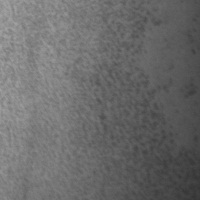

In [ ]:
def display_sample(
    dataset: pd.DataFrame,
    index: int,
    dataset_name: str = "Dataset",
    *,
    show_question: bool = True,
) -> None:
    """
    データセットから指定インデックスのサンプルを表示する。

    Args:
        dataset: 表示対象のDataFrame
        index: 表示するサンプルのインデックス
        dataset_name: 表示用のデータセット名
        show_question: 質問文を表示するかどうか
    """
    if index >= len(dataset):
        print(f"⚠️ インデックス {index} は範囲外です（データセットサイズ: {len(dataset)}）")
        return

    sample = dataset.iloc[index]
    print(f"📊 {dataset_name} - サンプル #{index}")
    print(f"{'─' * 40}")
    if show_question:
        print(f"💬 質問: {sample['question']}")
    print(f"🏷️ 正解: {sample['answer']}")
    display(sample["image"])


# Train データセットのサンプル表示
display_sample(ds_train, index=46, dataset_name="Train")

📊 Validation - サンプル #10
────────────────────────────────────────
💬 質問: この画像に写っている鋼材表面の欠陥タイプを分類してください。
🏷️ 正解: crazing


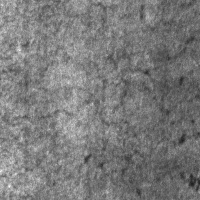

In [ ]:
# Validation データセットのサンプル表示
display_sample(ds_val, index=10, dataset_name="Validation")

📊 Test - サンプル #0
────────────────────────────────────────
💬 質問: この画像に写っている鋼材表面の欠陥タイプを分類してください。
🏷️ 正解: inclusion


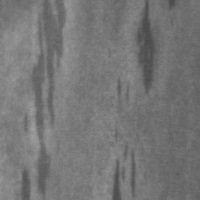

In [ ]:
# Test データセットのサンプル表示
display_sample(ds_test, index=0, dataset_name="Test")

### JSONL ファイルの生成

Azure OpenAI / OpenAI の Vision ファインチューニング用に、データセットを JSONL (JSON Lines) 形式に変換します。

**公式ドキュメント準拠のメッセージ構造:**
```json
{
  "messages": [
    {"role": "system", "content": "<システムプロンプト>"},
    {"role": "user", "content": "<質問テキスト>"},
    {"role": "user", "content": [{"type": "image_url", "image_url": {"url": "...", "detail": "low"}}]},
    {"role": "assistant", "content": "<正解ラベル>"}
  ]
}
```

**注意事項:**
- `detail` パラメータは `"low"` または `"high"` を指定
- 画像は Base64 エンコードされた Data URL 形式
- 各行は独立した JSON オブジェクト

In [ ]:
"""
JSONL ファイル生成モジュール

Azure OpenAI Vision ファインチューニング用のデータセットを
Chat Completion API 形式の JSONL に変換する。

公式ドキュメント準拠:
- https://platform.openai.com/docs/guides/vision-fine-tuning
- https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning

メッセージ構造:
    [
        {"role": "system", "content": "<システムプロンプト>"},
        {"role": "user", "content": "<質問テキスト>"},
        {"role": "user", "content": [{"type": "image_url", "image_url": {...}}]},
        {"role": "assistant", "content": "<正解ラベル>"}
    ]
"""
from dataclasses import dataclass, field
from enum import Enum
from typing import NamedTuple

# ─────────────────────────────────────────────────────────────
# 定数・Enum
# ─────────────────────────────────────────────────────────────
BASE64_IMAGE_PREFIX: str = "data:image/jpeg;base64,"
JSONL_IMAGE_ENCODE_QUALITY: int = 80  # JPEG品質 (1-100)

# JSONL ファイル出力ディレクトリ（画像データと同じ親フォルダ内に配置）
JSONL_OUTPUT_DIR: Path = DatasetPaths.default().output_dir / "jsonl"


class ImageDetail(str, Enum):
    """Vision API の画像解像度設定

    公式ドキュメントより:
    - low: 512x512にリサイズ、85トークン固定（コスト削減）
    - high: 高解像度処理（より多くのトークンを消費）
    - auto: モデルが自動判定

    参考: https://platform.openai.com/docs/guides/vision#low-or-high-fidelity-image-understanding
    """

    LOW = "low"
    HIGH = "high"
    AUTO = "auto"


# ─────────────────────────────────────────────────────────────
# データ構造
# ─────────────────────────────────────────────────────────────
class ChatMessage(NamedTuple):
    """Chat Completion API のメッセージ構造"""

    messages: list[dict[str, object]]


@dataclass(frozen=True)
class JsonlGenerationConfig:
    """JSONL生成の設定

    Attributes:
        project_name: プロジェクト名（ファイル名に使用）
        system_prompt: システムプロンプト（role=system）
        image_quality: JPEG圧縮品質 (1-100)
        image_detail: Vision API の解像度設定
        output_dir: JSONL出力ディレクトリ
    """

    project_name: str
    system_prompt: str
    image_quality: int = JSONL_IMAGE_ENCODE_QUALITY
    image_detail: ImageDetail = ImageDetail.LOW  # コスト削減のためデフォルトはlow
    output_dir: Path = field(default_factory=lambda: JSONL_OUTPUT_DIR)

    def get_output_path(self, split_name: str) -> Path:
        """
        分割名に対応する出力ファイルパスを取得

        ファイル名形式: {project_name}_{split_name}.jsonl
        例: metal-defect-gpt41_train.jsonl
        """
        return self.output_dir / f"{self.project_name}_{split_name}.jsonl"


# ─────────────────────────────────────────────────────────────
# 内部関数
# ─────────────────────────────────────────────────────────────
def _build_chat_message(
    question: str,
    image: Image.Image,
    answer: str,
    *,
    system_prompt: str,
    image_quality: int = JSONL_IMAGE_ENCODE_QUALITY,
    image_detail: ImageDetail = ImageDetail.LOW,
) -> ChatMessage:
    """
    Chat Completion API に送るメッセージ形式を生成する。

    Vision ファインチューニングの公式形式に準拠:
    - system: タスクの指示・コンテキスト
    - user (text): 質問文
    - user (image): 画像データ
    - assistant: 期待される回答

    Args:
        question: ユーザーの質問文
        image: エンコードする PIL 画像
        answer: 期待される応答（正解ラベル）
        system_prompt: システムプロンプト
        image_quality: JPEG品質 (1-100)
        image_detail: 画像解像度設定（low推奨でコスト削減）

    Returns:
        ChatMessage: Chat Completion 形式のメッセージ
    """
    encoded_image = encode_image(image, quality=image_quality)

    return ChatMessage(
        messages=[
            # 1. システムプロンプト: タスクの定義と指示
            {"role": "system", "content": system_prompt},
            # 2. ユーザー質問文: テキストとして送信
            {"role": "user", "content": question},
            # 3. ユーザー画像: 別のメッセージとして送信（公式形式）
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"{BASE64_IMAGE_PREFIX}{encoded_image}",
                            "detail": image_detail.value,  # low/high/auto
                        },
                    },
                ],
            },
            # 4. アシスタント回答: 正解ラベル
            {"role": "assistant", "content": answer},
        ]
    )


def _convert_dataset_to_jsonl_records(
    dataset: pd.DataFrame,
    *,
    system_prompt: str,
    image_quality: int = JSONL_IMAGE_ENCODE_QUALITY,
    image_detail: ImageDetail = ImageDetail.LOW,
) -> list[dict[str, object]]:
    """
    DataFrame を JSONL 用のレコードリストに変換する。

    Args:
        dataset: image, question, answer 列を持つ DataFrame
        system_prompt: システムプロンプト
        image_quality: JPEG品質
        image_detail: 画像解像度設定

    Returns:
        Chat Completion 形式の辞書リスト
    """
    records: list[dict[str, object]] = []
    errors: list[tuple[int, str]] = []

    for idx, row in tqdm(enumerate(dataset.itertuples()), total=len(dataset), desc="変換中"):
        try:
            message = _build_chat_message(
                question=row.question,
                image=row.image,
                answer=row.answer,
                system_prompt=system_prompt,
                image_quality=image_quality,
                image_detail=image_detail,
            )
            records.append(message._asdict())
        except AttributeError as e:
            errors.append((idx, f"必須フィールドが見つかりません: {e}"))
        except Exception as e:
            errors.append((idx, f"処理エラー: {e}"))

    # エラーサマリー
    if errors:
        print(f"\n⚠️ {len(errors)} 件のエラーが発生:")
        for idx, msg in errors[:5]:  # 最初の5件のみ表示
            print(f"  サンプル {idx}: {msg}")
        if len(errors) > 5:
            print(f"  ... 他 {len(errors) - 5} 件")

    return records


def _write_jsonl(filepath: Path, records: list[dict[str, object]]) -> int:
    """
    レコードを JSONL ファイルに書き出す。

    Args:
        filepath: 出力ファイルパス
        records: 書き込むレコードのリスト

    Returns:
        書き込んだレコード数

    Note:
        - UTF-8 エンコーディングで出力
        - 日本語文字はそのまま保持（ensure_ascii=False）
    """
    filepath.parent.mkdir(parents=True, exist_ok=True)
    with filepath.open("w", encoding="utf-8") as f:
        for record in records:
            json.dump(record, f, ensure_ascii=False)
            f.write("\n")
    return len(records)


# ─────────────────────────────────────────────────────────────
# 公開関数
# ─────────────────────────────────────────────────────────────
def generate_jsonl_files(
    splits: dict[str, pd.DataFrame],
    config: JsonlGenerationConfig,
) -> dict[str, Path]:
    """
    複数のデータセットから JSONL ファイルを生成する。

    Args:
        splits: 分割名 → DataFrame のマッピング
                例: {"train": ds_train, "val": ds_val, "test": ds_test}
        config: JSONL生成の設定

    Returns:
        分割名 → 生成されたファイルパスのマッピング

    Example:
        >>> config = JsonlGenerationConfig(project_name="my_project", system_prompt=SYSTEM_PROMPT)
        >>> files = generate_jsonl_files({"train": ds_train, "val": ds_val}, config)
    """
    generated_files: dict[str, Path] = {}

    print(f"📄 JSONL ファイル生成開始")
    print(f"📁 出力先: {config.output_dir}")
    print(f"🖼️  画像解像度: {config.image_detail.value} (detail)")
    print(f"{'─' * 50}")

    for split_name, dataset in splits.items():
        filepath = config.get_output_path(split_name)
        print(f"\n📝 {split_name}: {len(dataset)} サンプル → {filepath.name}")

        records = _convert_dataset_to_jsonl_records(
            dataset,
            system_prompt=config.system_prompt,
            image_quality=config.image_quality,
            image_detail=config.image_detail,
        )
        count = _write_jsonl(filepath, records)
        generated_files[split_name] = filepath

        size_kb = filepath.stat().st_size / 1024
        print(f"   ✅ 完了: {count} レコード, {size_kb:.1f} KB")

    print(f"\n{'─' * 50}")
    print(f"✅ 全 {len(generated_files)} ファイルの生成が完了しました")

    return generated_files


# ─────────────────────────────────────────────────────────────
# JSONL ファイル生成の実行
# ─────────────────────────────────────────────────────────────
jsonl_config = JsonlGenerationConfig(
    project_name=project_name,
    system_prompt=SYSTEM_PROMPT,
    image_detail=ImageDetail.LOW,  # コスト削減のためlow（512x512、85トークン固定）
)

dataset_splits = {
    "train": ds_train,
    "val": ds_val,
    "test": ds_test,
}

generated_files = generate_jsonl_files(dataset_splits, jsonl_config)

In [ ]:
# 生成されたファイルの一覧を表示
print("📁 生成された JSONL ファイル:")
print(f"{'─' * 50}")
for split_name, filepath in generated_files.items():
    size_kb = filepath.stat().st_size / 1024
    print(f"  {split_name:10}: {filepath.name:30} ({size_kb:>8.1f} KB)")

📁 生成された JSONL ファイル:
──────────────────────────────────────────────────
  train     : steel-surface-defects-gpt41_train.jsonl (  2982.1 KB)
  val       : steel-surface-defects-gpt41_val.jsonl (   605.9 KB)
  test      : steel-surface-defects-gpt41_test.jsonl (   594.9 KB)


### JSONL ファイルのプレビュー

生成された JSONL ファイルの内容を確認します。各行は Chat Completion API のリクエスト形式になっています。

In [ ]:
def preview_jsonl(
    filepath: Path,
    *,
    max_content_length: int = 80,
    max_image_url_length: int = 50,
) -> None:
    """
    JSONL ファイルの最初のレコードをプレビュー表示する。

    Vision ファインチューニング形式のJSONLを可読性のある形式で表示する。
    メッセージ構造:
    - system: タスク指示
    - user (text): 質問文
    - user (image): 画像データ
    - assistant: 正解ラベル

    Args:
        filepath: JSONLファイルのパス
        max_content_length: テキストコンテンツの表示最大文字数
        max_image_url_length: 画像URLの表示最大文字数
    """
    print(f"📄 ファイル: {filepath.name}")
    print(f"{'─' * 60}")

    with filepath.open("r", encoding="utf-8") as f:
        first_line = f.readline()

    data = json.loads(first_line)
    messages = data.get("messages", [])

    for i, msg in enumerate(messages, 1):
        role = msg.get("role", "unknown")
        content = msg.get("content", "")

        # ロールに応じたアイコン
        role_icons = {
            "system": "⚙️",
            "user": "👤",
            "assistant": "🤖",
        }
        icon = role_icons.get(role, "❓")

        # コンテンツの表示
        if isinstance(content, str):
            # テキストコンテンツ
            preview = content[:max_content_length]
            if len(content) > max_content_length:
                preview += "..."
            print(f"{icon} [{i}] {role}: {preview}")

        elif isinstance(content, list):
            # 配列コンテンツ（通常は画像）
            print(f"{icon} [{i}] {role}:")
            for item in content:
                item_type = item.get("type", "unknown")
                if item_type == "text":
                    text = item.get("text", "")
                    preview = text[:max_content_length]
                    if len(text) > max_content_length:
                        preview += "..."
                    print(f"     📝 [text] {preview}")
                elif item_type == "image_url":
                    image_info = item.get("image_url", {})
                    url = image_info.get("url", "")
                    detail = image_info.get("detail", "auto")
                    url_preview = url[:max_image_url_length]
                    print(f"     🖼️  [image] {url_preview}... ({len(url):,} chars, detail={detail})")
                else:
                    print(f"     ❓ [{item_type}] (unknown type)")


# Train ファイルのプレビュー
preview_jsonl(generated_files["train"])

📄 ファイル: steel-surface-defects-gpt41_train.jsonl
────────────────────────────────────────────────────────────
⚙️ [1] system: あなたは鋼材表面の欠陥を分類する専門家です。

【タスク】
提供された画像を分析し、鋼材表面の欠陥タイプを特定してください。

【分類クラス】（6種類）
rol...
👤 [2] user: この画像に写っている鋼材表面の欠陥タイプを分類してください。
👤 [3] user:
     🖼️  [image] data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD... (16,547 chars, detail=low)
🤖 [4] assistant: patches
⚙️ [1] system: あなたは鋼材表面の欠陥を分類する専門家です。

【タスク】
提供された画像を分析し、鋼材表面の欠陥タイプを特定してください。

【分類クラス】（6種類）
rol...
👤 [2] user: この画像に写っている鋼材表面の欠陥タイプを分類してください。
👤 [3] user:
     🖼️  [image] data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD... (16,547 chars, detail=low)
🤖 [4] assistant: patches


## 4 ファインチューニング

### 4.1 ファインチューニング用ファイルのアップロード

In [ ]:
@dataclass
class UploadedFile:
    """アップロードされたファイルの情報を保持するクラス。"""

    id: str


def upload_jsonl_file(filepath: PathLike, purpose: str = "fine-tune") -> UploadedFile:
    """
    JSONLファイルをAzure OpenAIにアップロードする。

    Args:
        filepath: アップロードするファイルのパス
        purpose: ファイルの用途 (default: "fine-tune")

    Returns:
        アップロードされたファイル情報

    Raises:
        FileNotFoundError: ファイルが存在しない場合
        ValueError: ファイルが空の場合
    """
    path = Path(filepath)

    # ファイル存在チェック
    if not path.exists():
        raise FileNotFoundError(f"ファイルが見つかりません: {path}")

    # ファイルサイズチェック
    file_size = path.stat().st_size
    if file_size == 0:
        raise ValueError(f"ファイルが空です: {path}")

    size_mb = file_size / (1024 * 1024)
    print(f"📤 アップロード中: {path.name} ({size_mb:.2f} MB)")

    with path.open("rb") as f:
        response = client.files.create(file=f, purpose=purpose)

    print(f"   ✅ 完了: {response.id}")
    return UploadedFile(id=response.id)


# generated_files から直接パスを取得してアップロード
print("📁 ファインチューニング用ファイルのアップロード")
print(f"{'─' * 50}")

train_file = upload_jsonl_file(generated_files["train"])
val_file = upload_jsonl_file(generated_files["val"])

print(f"{'─' * 50}")
print("✅ 全ファイルのアップロードが完了しました")

📁 ファインチューニング用ファイルのアップロード
──────────────────────────────────────────────────
📤 アップロード中: steel-surface-defects-gpt41_train.jsonl (2.91 MB)
   ✅ 完了: file-72d3380a9fbe479883bc005b45fff84e
📤 アップロード中: steel-surface-defects-gpt41_val.jsonl (0.59 MB)
   ✅ 完了: file-72d3380a9fbe479883bc005b45fff84e
📤 アップロード中: steel-surface-defects-gpt41_val.jsonl (0.59 MB)
   ✅ 完了: file-9c8661b6a2484858b4ee37a39428931d
──────────────────────────────────────────────────
✅ 全ファイルのアップロードが完了しました
   ✅ 完了: file-9c8661b6a2484858b4ee37a39428931d
──────────────────────────────────────────────────
✅ 全ファイルのアップロードが完了しました


### 4.2 ファインチューニングジョブの作成と実行

#### 4.2.1 ハイパーパラメータの設定

ファインチューニングのハイパーパラメータを調整できます。  
`None` を指定すると、Azure OpenAI / OpenAI がデータセットに基づいて最適なデフォルト値を自動設定します。

| パラメータ | 説明 | デフォルト |
|-----------|------|-----------|
| `n_epochs` | トレーニングエポック数 | auto |
| `batch_size` | バッチサイズ | auto |
| `learning_rate_multiplier` | 学習率の倍率 | auto |

In [ ]:
# ベースモデル名
# Vision ファインチューニング対応モデル
# 参考: https://platform.openai.com/docs/guides/vision-fine-tuning
BASELINE_MODEL: str = "gpt-4.1-2025-04-14"
print(f"🤖 ベースモデル: {BASELINE_MODEL}")

🤖 ベースモデル: gpt-4.1-2025-04-14


In [ ]:
"""
ファインチューニングジョブの作成

Azure OpenAI / OpenAI の Fine-tuning API を使用してジョブを作成する。

公式ドキュメント:
- https://platform.openai.com/docs/api-reference/fine-tuning/create
- https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning

Note:
    `hyperparameters` パラメータは deprecated。
    最新のAPIでは `method` パラメータ内で指定することが推奨されているが、
    Azure OpenAI SDK では従来の形式も引き続きサポートされている。
"""
from dataclasses import dataclass
from enum import Enum
from typing import Any


class FineTuningMethod(str, Enum):
    """ファインチューニング手法"""

    SUPERVISED = "supervised"  # Supervised Fine-Tuning (SFT)
    DPO = "dpo"  # Direct Preference Optimization


@dataclass(frozen=True)
class SupervisedHyperparameters:
    """Supervised Fine-Tuning のハイパーパラメータ

    Attributes:
        n_epochs: トレーニングエポック数（None で自動設定）
        batch_size: バッチサイズ（None で自動設定、データの約0.2%、最大256）
        learning_rate_multiplier: 学習率乗数（None で自動設定、推奨: 0.02〜0.2）
    """

    n_epochs: int | None = None
    batch_size: int | None = None
    learning_rate_multiplier: float | None = None

    def to_dict(self) -> dict[str, int | float]:
        """None でない値のみを含む辞書を返す"""
        return {k: v for k, v in vars(self).items() if v is not None}


@dataclass(frozen=True)
class FineTuningJobConfig:
    """ファインチューニングジョブの設定

    Attributes:
        training_file: トレーニングデータのファイルID
        validation_file: 検証データのファイルID
        model: ベースモデル名
        suffix: モデル名のサフィックス（最大64文字）
        seed: 再現性制御用シード（None でランダム生成）
        hyperparameters: ハイパーパラメータ設定
        method: ファインチューニング手法
    """

    training_file: str
    validation_file: str
    model: str
    suffix: str
    seed: int | None = None
    hyperparameters: SupervisedHyperparameters | None = None
    method: FineTuningMethod = FineTuningMethod.SUPERVISED


def create_fine_tuning_job(client: OpenAI, config: FineTuningJobConfig) -> Any:
    """
    ファインチューニングジョブを作成する。

    Args:
        client: OpenAI クライアント
        config: ジョブ設定

    Returns:
        作成されたファインチューニングジョブオブジェクト

    Example:
        >>> config = FineTuningJobConfig(
        ...     training_file="file-xxx",
        ...     validation_file="file-yyy",
        ...     model="gpt-4.1-2025-04-14",
        ...     suffix="my-model",
        ... )
        >>> job = create_fine_tuning_job(client, config)
    """
    # ハイパーパラメータの構築
    hyperparameters = config.hyperparameters.to_dict() if config.hyperparameters else None

    # ジョブ作成パラメータ
    job_params: dict[str, Any] = {
        "training_file": config.training_file,
        "validation_file": config.validation_file,
        "model": config.model,
        "suffix": config.suffix,
    }

    # オプションパラメータの追加
    if config.seed is not None:
        job_params["seed"] = config.seed
    if hyperparameters:
        job_params["hyperparameters"] = hyperparameters

    return client.fine_tuning.jobs.create(**job_params)


# ─────────────────────────────────────────────────────────────
# ジョブ設定の作成
# ─────────────────────────────────────────────────────────────

# ハイパーパラメータ（None = 自動設定）
hyperparams = SupervisedHyperparameters(
    n_epochs=None,  # 自動設定
    batch_size=None,  # 自動設定
    learning_rate_multiplier=None,  # 自動設定
)

# ジョブ設定
ft_config = FineTuningJobConfig(
    training_file=train_file.id,
    validation_file=val_file.id,
    model=BASELINE_MODEL,
    suffix=project_name,
    seed=42,  # 再現性のためにシードを固定
    hyperparameters=hyperparams,
)

print("📋 ファインチューニングジョブ設定:")
print(f"  ベースモデル: {ft_config.model}")
print(f"  サフィックス: {ft_config.suffix}")
print(f"  シード: {ft_config.seed}")
print(f"  トレーニングファイル: {ft_config.training_file}")
print(f"  検証ファイル: {ft_config.validation_file}")

# ─────────────────────────────────────────────────────────────
# ジョブの作成
# ─────────────────────────────────────────────────────────────
ft_job = create_fine_tuning_job(client, ft_config)
print(f"\n✅ ファインチューニングジョブを作成しました")
print(f"   ジョブID: {ft_job.id}")
print(f"   ステータス: {ft_job.status}")

📋 ファインチューニングジョブ設定:
  ベースモデル: gpt-4.1-2025-04-14
  サフィックス: steel-surface-defects-gpt41
  シード: 42
  トレーニングファイル: file-72d3380a9fbe479883bc005b45fff84e
  検証ファイル: file-9c8661b6a2484858b4ee37a39428931d

✅ ファインチューニングジョブを作成しました
   ジョブID: ftjob-897417f8175a47ed89d868fd05d6a204
   ステータス: pending

✅ ファインチューニングジョブを作成しました
   ジョブID: ftjob-897417f8175a47ed89d868fd05d6a204
   ステータス: pending


In [ ]:
# ジョブ定義の詳細を表示
get_ft_job_definition(ft_job)

In [ ]:
# ジョブIDを変数に保存（以降のセルで使用）
JOB_ID: str = ft_job.id
print(f"📌 ジョブID: {JOB_ID}")

In [ ]:
# ジョブ情報の取得
get_ft_job_info(client=client, job_id=JOB_ID)

### 4.3 ファインチューニングジョブの監視

In [ ]:
# 最新のファインチューニングジョブ一覧を取得（最大5件）
MAX_JOBS_TO_LIST: int = 5

ft_jobs_response = client.fine_tuning.jobs.list(limit=MAX_JOBS_TO_LIST)
ft_jobs_df = pd.DataFrame(ft_jobs_response.to_dict()["data"])

print(f"📋 最新 {len(ft_jobs_df)} 件のファインチューニングジョブ:")
date_sorted_df(ft_jobs_df)

#### 4.3.1 現在のジョブステータス確認

In [ ]:
# ジョブのステータスを確認
get_ft_status(client, JOB_ID)

In [ ]:
# ジョブの詳細情報を取得
get_ft_job_info(client, JOB_ID)

#### 4.3.2 ジョブイベント履歴

In [ ]:
# ジョブのイベント履歴を取得
get_ft_list_of_events(client, JOB_ID)

#### 4.3.3 ジョブ実行中の監視

ジョブが `running` 状態の間、定期的にステータスを確認します。

In [ ]:
# ジョブステータスの確認（実行中）
get_ft_status(client, JOB_ID)

In [ ]:
# イベント履歴の確認（トレーニング進捗）
get_ft_list_of_events(client, JOB_ID)

In [ ]:
# ジョブ詳細情報の確認
get_ft_job_info(client, JOB_ID)

#### 4.3.4 Microsoft Foundry ポータルでの確認

Microsoft Foundry ポータル（[ai.azure.com](https://ai.azure.com)）でもジョブの進捗を確認できます。
`Running/実行しています` ステータスとなっていることが確認できます。

![ジョブ実行中](picture/ft-job-running.png)

In [ ]:
# 最新ジョブのステータス確認
get_ft_status(client, JOB_ID)

In [ ]:
# 最新のジョブ情報を確認
client.fine_tuning.jobs.list(limit=1).to_dict()

#### 4.3.5 ジョブ完了待機

ファインチューニングジョブが完了（`succeeded` または `failed`）するまで待機します。

In [ ]:
# 待機前のステータス確認
get_ft_status(client, JOB_ID)

In [ ]:
# 待機前のイベント履歴
get_ft_list_of_events(client, JOB_ID)

In [ ]:
from enum import Enum


class JobStatus(str, Enum):
    """ファインチューニングジョブのステータス"""

    VALIDATING_FILES = "validating_files"
    QUEUED = "queued"
    RUNNING = "running"
    SUCCEEDED = "succeeded"
    FAILED = "failed"
    CANCELLED = "cancelled"


# 待機設定
POLL_INTERVAL_SECONDS: int = 600  # 10分間隔でポーリング
TERMINAL_STATUSES: set[str] = {
    JobStatus.SUCCEEDED.value,
    JobStatus.FAILED.value,
    JobStatus.CANCELLED.value,
}


def wait_for_fine_tuning_job(
    client: AzureOpenAI,
    job_id: str,
    poll_interval: int = POLL_INTERVAL_SECONDS,
) -> str:
    """
    ファインチューニングジョブが完了するまで待機します。

    Args:
        client: AzureOpenAI クライアント
        job_id: ファインチューニングジョブID
        poll_interval: ポーリング間隔（秒）

    Returns:
        最終ステータス（succeeded, failed, cancelled のいずれか）
    """
    print(f"ジョブ {job_id} の完了を待機中...")
    print(f"ポーリング間隔: {poll_interval // 60}分")
    print("-" * 50)

    iteration = 0
    while True:
        iteration += 1
        response = client.fine_tuning.jobs.retrieve(job_id)
        status = response.status
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        # ステータス情報の表示
        clear_output(wait=True)
        print(f"🔄 ポーリング #{iteration} - {current_time}")
        print(f"   ジョブID: {job_id}")
        print(f"   ステータス: {status}")

        if response.trained_tokens:
            print(f"   トレーニング済みトークン: {response.trained_tokens:,}")

        print("-" * 50)

        # 終了条件のチェック
        if status in TERMINAL_STATUSES:
            status_emoji = "✅" if status == JobStatus.SUCCEEDED.value else "❌"
            print(f"\n{status_emoji} ジョブが完了しました！")
            print(f"   最終ステータス: {status}")
            if response.fine_tuned_model:
                print(f"   ファインチューニングモデル: {response.fine_tuned_model}")
            return status

        # 次のポーリングまで待機
        print(f"⏳ 次のチェックまで {poll_interval // 60}分 待機中...")
        time.sleep(poll_interval)


# ジョブ完了を待機
final_status = wait_for_fine_tuning_job(client, JOB_ID)

🔄 ポーリング #1 - 2025-12-02 20:31:52
   ジョブID: ftjob-897417f8175a47ed89d868fd05d6a204
   ステータス: succeeded
   トレーニング済みトークン: 2,221,104
--------------------------------------------------

✅ ジョブが完了しました！
   最終ステータス: succeeded
   ファインチューニングモデル: gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd05d6a204-steel-surface-defects-gpt41


In [ ]:
# 完了後のジョブ情報確認
client.fine_tuning.jobs.list(limit=1).to_dict()

{'data': [{'id': 'ftjob-897417f8175a47ed89d868fd05d6a204',
   'created_at': 1764663300,
   'fine_tuned_model': 'gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd05d6a204-steel-surface-defects-gpt41',
   'finished_at': 1764668437,
   'hyperparameters': {'batch_size': 1,
    'learning_rate_multiplier': 2.0,
    'n_epochs': 3},
   'model': 'gpt-4.1-2025-04-14',
   'object': 'fine_tuning.job',
   'result_files': ['file-afe8f0794b944b748ebbae657070658a'],
   'seed': 42,
   'status': 'succeeded',
   'trained_tokens': 2221104,
   'training_file': 'file-72d3380a9fbe479883bc005b45fff84e',
   'validation_file': 'file-9c8661b6a2484858b4ee37a39428931d',
   'estimated_finish': 1764709472,
   'suffix': 'steel-surface-defects-gpt41',
   'trainingType': 'standard'}],
 'has_more': False,
 'object': 'list'}

In [68]:
# 完了後のジョブ詳細
get_ft_job_info(client, JOB_ID)

2025-12-02 20:32:00
Job ID: ftjob-897417f8175a47ed89d868fd05d6a204
Status: succeeded
{
  "id": "ftjob-897417f8175a47ed89d868fd05d6a204",
  "created_at": 1764663300,
  "error": null,
  "fine_tuned_model": "gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd05d6a204-steel-surface-defects-gpt41",
  "finished_at": 1764668437,
  "hyperparameters": {
    "batch_size": 1,
    "learning_rate_multiplier": 2.0,
    "n_epochs": 3
  },
  "model": "gpt-4.1-2025-04-14",
  "object": "fine_tuning.job",
  "organization_id": null,
  "result_files": [
    "file-afe8f0794b944b748ebbae657070658a"
  ],
  "seed": 42,
  "status": "succeeded",
  "trained_tokens": 2221104,
  "training_file": "file-72d3380a9fbe479883bc005b45fff84e",
  "validation_file": "file-9c8661b6a2484858b4ee37a39428931d",
  "estimated_finish": 1764709472,
  "integrations": null,
  "metadata": null,
  "method": null,
  "suffix": "steel-surface-defects-gpt41",
  "trainingType": "standard"
}
Job ID: ftjob-897417f8175a47ed89d868fd05d6a204
Status: su

FineTuningJobInfo(job_id='ftjob-897417f8175a47ed89d868fd05d6a204', status='succeeded', raw_json='{\n  "id": "ftjob-897417f8175a47ed89d868fd05d6a204",\n  "created_at": 1764663300,\n  "error": null,\n  "fine_tuned_model": "gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd05d6a204-steel-surface-defects-gpt41",\n  "finished_at": 1764668437,\n  "hyperparameters": {\n    "batch_size": 1,\n    "learning_rate_multiplier": 2.0,\n    "n_epochs": 3\n  },\n  "model": "gpt-4.1-2025-04-14",\n  "object": "fine_tuning.job",\n  "organization_id": null,\n  "result_files": [\n    "file-afe8f0794b944b748ebbae657070658a"\n  ],\n  "seed": 42,\n  "status": "succeeded",\n  "trained_tokens": 2221104,\n  "training_file": "file-72d3380a9fbe479883bc005b45fff84e",\n  "validation_file": "file-9c8661b6a2484858b4ee37a39428931d",\n  "estimated_finish": 1764709472,\n  "integrations": null,\n  "metadata": null,\n  "method": null,\n  "suffix": "steel-surface-defects-gpt41",\n  "trainingType": "standard"\n}')

In [ ]:
# 完了後のイベント履歴
get_ft_list_of_events(client, JOB_ID)

2025-12-02 20:32:01
{
  "data": [
    {
      "id": "ftevent-5cacf5fd0252448f84918a91602fc112",
      "created_at": 1764668437,
      "level": "info",
      "message": "Training tokens billed: 197000",
      "object": "fine_tuning.job.event",
      "data": null,
      "type": "message"
    },
    {
      "id": "ftevent-ffeb74daff2046619a0991ae92a43c75",
      "created_at": 1764668437,
      "level": "info",
      "message": "Model Evaluation Passed.",
      "object": "fine_tuning.job.event",
      "data": null,
      "type": "message"
    },
    {
      "id": "ftevent-e31d5b8114024743b244e7ec01b00061",
      "created_at": 1764668437,
      "level": "info",
      "message": "Completed results file: file-afe8f0794b944b748ebbae657070658a",
      "object": "fine_tuning.job.event",
      "data": null,
      "type": "message"
    },
    {
      "id": "ftevent-6def39f668a84663a230bfcaf1833b70",
      "created_at": 1764668425,
      "level": "info",
      "message": "Job succeeded.",
      "ob

'{\n  "data": [\n    {\n      "id": "ftevent-5cacf5fd0252448f84918a91602fc112",\n      "created_at": 1764668437,\n      "level": "info",\n      "message": "Training tokens billed: 197000",\n      "object": "fine_tuning.job.event",\n      "data": null,\n      "type": "message"\n    },\n    {\n      "id": "ftevent-ffeb74daff2046619a0991ae92a43c75",\n      "created_at": 1764668437,\n      "level": "info",\n      "message": "Model Evaluation Passed.",\n      "object": "fine_tuning.job.event",\n      "data": null,\n      "type": "message"\n    },\n    {\n      "id": "ftevent-e31d5b8114024743b244e7ec01b00061",\n      "created_at": 1764668437,\n      "level": "info",\n      "message": "Completed results file: file-afe8f0794b944b748ebbae657070658a",\n      "object": "fine_tuning.job.event",\n      "data": null,\n      "type": "message"\n    },\n    {\n      "id": "ftevent-6def39f668a84663a230bfcaf1833b70",\n      "created_at": 1764668425,\n      "level": "info",\n      "message": "Job succeede

#### 4.3.6 ジョブ完了確認

ファインチューニングジョブが正常に完了しました。

![ジョブ完了](picture/ft-job-completed.png)

#### 4.3.7 トレーニングメトリクスの確認

ファインチューニングジョブの結果とトレーニングメトリクスを確認します。

メトリクス説明:

| メトリック | 説明 |
|------------|------|
| `step` | トレーニングステップの数。トレーニングステップは、トレーニングデータのバッチに対する1回の前進と後退を表す |
| `train_loss` / `validation_loss` | トレーニング/バリデーションバッチの損失 |
| `train_mean_token_accuracy` | トレーニングバッチ内のトークンがモデルによって正しく予測された割合 |
| `validation_mean_token_accuracy` | バリデーションバッチ内のトークンがモデルによって正しく予測された割合 |

In [ ]:
# メトリクス確認前のステータス
get_ft_status(client, JOB_ID)

In [ ]:
# ファインチューニングジョブの詳細を取得
ft_job = client.fine_tuning.jobs.retrieve(JOB_ID)
ft_job_dict = ft_job.to_dict()

In [72]:
# トレーニング時間の計算と表示
start_timestamp = ft_job_dict["created_at"]
end_timestamp = ft_job_dict["finished_at"]

start_dt = datetime.fromtimestamp(start_timestamp)
end_dt = datetime.fromtimestamp(end_timestamp)
elapsed = end_dt - start_dt

print("📊 トレーニングサマリー")
print("=" * 50)
print(f"開始時刻: {start_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"終了時刻: {end_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"所要時間: {elapsed}")
print()

trained_tokens = ft_job_dict.get("trained_tokens", 0)
print(f"トレーニング済みトークン数: {trained_tokens:,}")

if ft_job.fine_tuned_model:
    print(f"ファインチューニングモデル: {ft_job.fine_tuned_model}")

📊 トレーニングサマリー
開始時刻: 2025-12-02 17:15:00
終了時刻: 2025-12-02 18:40:37
所要時間: 1:25:37

トレーニング済みトークン数: 2,221,104
ファインチューニングモデル: gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd05d6a204-steel-surface-defects-gpt41


In [ ]:
# 結果ファイルからファインチューニングのメトリクスを取得
result_file_id = ft_job.to_dict()["result_files"][0]
results_content = client.files.content(result_file_id).content.decode()
data_io = StringIO(results_content)
results_df = pd.read_csv(data_io)
show_ft_metrics(results_df)

## 5 ファインチューニングモデルのデプロイ

Azure SDK (`azure-mgmt-cognitiveservices`) を使用してファインチューニングモデルをデプロイします。

> ⚠️ **注意**  
> - カスタマイズされたモデルのデプロイは**1回のみ**許可されています。既にデプロイされたカスタマイズモデルを選択するとエラーが発生します。
> - デプロイ後 **15日以上** 推論呼び出しがない場合、デプロイメントは自動的に削除されます（モデル自体は削除されません）。
> - ファインチューニングモデルのデプロイには**時間課金**が発生します。

参照ドキュメント:
- [Azure OpenAI ファインチューニング - モデルのデプロイ](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning?tabs=turbo&pivots=programming-language-python#deploy-fine-tuned-model)
- [Deployments - Create Or Update API](https://learn.microsoft.com/en-us/rest/api/aiservices/accountmanagement/deployments/create-or-update?view=rest-aiservices-accountmanagement-2024-10-01&tabs=Python)

In [ ]:
# Azure OpenAI リソースに登録されているモデル一覧を取得
my_models = client.models.list().to_dict()
models_df = date_sorted_df(my_models["data"])

# 表示する列を定義
DISPLAY_COLUMNS: list[str] = [
    "status",
    "capabilities",
    "lifecycle_status",
    "id",
    "created_at",
    "model",
]

print("📋 Azure OpenAI リソースのモデル一覧:")
print(f"   登録モデル数: {len(models_df)}")
print(f"{'─' * 50}")
display(models_df[DISPLAY_COLUMNS].head())

📋 Azure OpenAI リソースのモデル一覧:
   登録モデル数: 260
──────────────────────────────────────────────────


status                                       capabilities  \
0  succeeded  {'fine_tune': True, 'inference': True, 'comple...   
1  succeeded  {'fine_tune': True, 'inference': True, 'comple...   
2  succeeded  {'fine_tune': True, 'inference': True, 'comple...   
3  succeeded  {'fine_tune': False, 'inference': True, 'compl...   
4  succeeded  {'fine_tune': False, 'inference': True, 'compl...   

      lifecycle_status                                                 id  \
0  generally-available  gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd...   
1  generally-available  gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd...   
2  generally-available  gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd...   
3              preview                           claude-opus-4-5-20251101   
4  generally-available                                 gpt-5.1-2025-11-13   

            created_at               model  
0  2025-12-02 08:15:00  gpt-4.1-2025-04-14  
1  2025-12-02 08:15:00  gpt-4.1-2025-04-14  
2  2025-12-02 08:15:00  gpt-4.1-2025-04-14  
3  2025-11-21 00:00:00                 NaN  
4  2025-11-11 00:00:00                 NaN

In [ ]:
# モデル一覧の全データを表示
models_df

id object     status  \
0    gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd...  model  succeeded   
1    gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd...  model  succeeded   
2    gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd...  model  succeeded   
3                             claude-opus-4-5-20251101  model  succeeded   
4                                   gpt-5.1-2025-11-13  model  succeeded   
..                                                 ...    ...        ...   
255                          text-search-curie-doc-001  model  succeeded   
256                                                ada  model  succeeded   
257                                            davinci  model  succeeded   
258                                            babbage  model  succeeded   
259                                              curie  model  succeeded   

                                          capabilities     lifecycle_status  \
0    {'fine_tune': True, 'inference': True, 'comple...  generally-available   
1    {'fine_tune': True, 'inference': True, 'comple...  generally-available   
2    {'fine_tune': True, 'inference': True, 'comple...  generally-available   
3    {'fine_tune': False, 'inference': True, 'compl...              preview   
4    {'fine_tune': False, 'inference': True, 'compl...  generally-available   
..                                                 ...                  ...   
255  {'fine_tune': False, 'inference': False, 'comp...           deprecated   
256  {'fine_tune': False, 'inference': False, 'comp...           deprecated   
257  {'fine_tune': False, 'inference': False, 'comp...           deprecated   
258  {'fine_tune': False, 'inference': False, 'comp...           deprecated   
259  {'fine_tune': False, 'inference': False, 'comp...           deprecated   

                                           deprecation           created_at  \
0                            {'inference': 1775865600}  2025-12-02 08:15:00   
1                            {'inference': 1775865600}  2025-12-02 08:15:00   
2                            {'inference': 1775865600}  2025-12-02 08:15:00   
3                            {'inference': 1773964800}  2025-11-21 00:00:00   
4    {'fine_tune': 1794355200, 'inference': 1794355...  2025-11-11 00:00:00   
..                                                 ...                  ...   
255                          {'inference': 1718323200}  2022-05-20 00:00:00   
256  {'fine_tune': 1718323200, 'inference': 1718323...  2022-03-01 00:00:00   
257  {'fine_tune': 1718323200, 'inference': 1718323...  2022-03-01 00:00:00   
258  {'fine_tune': 1718323200, 'inference': 1718323...  2022-03-01 00:00:00   
259  {'fine_tune': 1718323200, 'inference': 1718323...  2022-03-01 00:00:00   

                  model                               fine_tune  
0    gpt-4.1-2025-04-14  ftjob-897417f8175a47ed89d868fd05d6a204  
1    gpt-4.1-2025-04-14  ftjob-897417f8175a47ed89d868fd05d6a204  
2    gpt-4.1-2025-04-14  ftjob-897417f8175a47ed89d868fd05d6a204  
3                   NaN                                     NaN  
4                   NaN                                     NaN  
..                  ...                                     ...  
255                 NaN                                     NaN  
256                 NaN                                     NaN  
257                 NaN                                     NaN  
258                 NaN                                     NaN  
259                 NaN                                     NaN  

[260 rows x 9 columns]

In [ ]:
# 最新のファインチューニングモデルIDを取得
# モデルIDフォーマット: gpt-4.1-2025-04-14.ft-{job_id}
fine_tuned_model: str = models_df["id"].values[0].split(":")[0]
print(f"🎯 デプロイ対象モデル: {fine_tuned_model}")
print(
    f"   ベースモデル: {fine_tuned_model.split('.ft-')[0] if '.ft-' in fine_tuned_model else 'N/A'}"
)

🎯 デプロイ対象モデル: gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd05d6a204-steel-surface-defects-gpt41
   ベースモデル: gpt-4.1-2025-04-14


In [ ]:
# Azure SDK を使用したデプロイメント設定
# 参照: https://learn.microsoft.com/en-us/rest/api/aiservices/accountmanagement/deployments/create-or-update?view=rest-aiservices-accountmanagement-2024-10-01&tabs=Python
from dataclasses import dataclass
from enum import Enum
from typing import Any

from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient
from azure.mgmt.cognitiveservices.models import (
    Deployment,
    DeploymentModel,
    DeploymentProperties,
    Sku,
)


class DeploymentSkuName(str, Enum):
    """デプロイメントの SKU 名

    参照: https://learn.microsoft.com/en-us/rest/api/aiservices/accountmanagement/deployments/create-or-update#sku
    """

    STANDARD = "Standard"
    GLOBAL_STANDARD = "GlobalStandard"


class DeploymentProvisioningState(str, Enum):
    """デプロイメントのプロビジョニング状態

    参照: https://learn.microsoft.com/en-us/rest/api/aiservices/accountmanagement/deployments/create-or-update#deploymentprovisioningstate
    """

    ACCEPTED = "Accepted"
    CREATING = "Creating"
    DELETING = "Deleting"
    MOVING = "Moving"
    FAILED = "Failed"
    SUCCEEDED = "Succeeded"
    DISABLED = "Disabled"
    CANCELED = "Canceled"


# 終了状態の集合
DEPLOYMENT_TERMINAL_STATES: frozenset[str] = frozenset(
    {
        DeploymentProvisioningState.SUCCEEDED.value,
        DeploymentProvisioningState.FAILED.value,
        DeploymentProvisioningState.CANCELED.value,
    }
)


@dataclass(frozen=True)
class DeploymentConfig:
    """ファインチューニングモデルのデプロイメント設定"""

    deployment_name: str
    model_name: str
    model_format: str = "OpenAI"
    model_version: str = "1"
    sku_name: DeploymentSkuName = DeploymentSkuName.STANDARD
    sku_capacity: int = 1

    def to_deployment(self) -> Deployment:
        """Azure SDK の Deployment オブジェクトを生成"""
        return Deployment(
            sku=Sku(name=self.sku_name.value, capacity=self.sku_capacity),
            properties=DeploymentProperties(
                model=DeploymentModel(
                    format=self.model_format,
                    name=self.model_name,
                    version=self.model_version,
                )
            ),
        )


# Azure SDK クライアントの初期化
cognitive_client = CognitiveServicesManagementClient(
    credential=DefaultAzureCredential(),
    subscription_id=subscription_id,
)

# デプロイメント設定を作成
deploy_config = DeploymentConfig(
    deployment_name=project_name,  # 推論時に使用するデプロイメント名
    model_name=fine_tuned_model,
    sku_name=DeploymentSkuName.STANDARD,
    sku_capacity=1,
)

print("📝 デプロイメント設定:")
print(f"   デプロイメント名: {deploy_config.deployment_name}")
print(f"   モデル: {deploy_config.model_name}")
print(f"   モデルフォーマット: {deploy_config.model_format}")
print(f"   モデルバージョン: {deploy_config.model_version}")
print(f"   SKU: {deploy_config.sku_name.value} (容量: {deploy_config.sku_capacity})")
print(f"{'─' * 50}")
print(f"   リソースグループ: {rg_name}")
print(f"   Cognitive Services アカウント: {resource_name}")

In [ ]:
# デプロイメント設定の確認（SDK オブジェクト）
deployment_obj = deploy_config.to_deployment()

print("📋 デプロイメントリクエスト内容:")
print(f"   SKU: {deployment_obj.sku.name} (capacity: {deployment_obj.sku.capacity})")
print(f"   Model Format: {deployment_obj.properties.model.format}")
print(f"   Model Name: {deployment_obj.properties.model.name}")
print(f"   Model Version: {deployment_obj.properties.model.version}")

📋 デプロイメントリクエスト内容:
   SKU: Standard (capacity: 1)
   Model Format: OpenAI
   Model Name: gpt-4.1-2025-04-14.ft-897417f8175a47ed89d868fd05d6a204-steel-surface-defects-gpt41
   Model Version: 1


In [ ]:
# デプロイメントの実行 (Azure SDK を使用)
# begin_create_or_update は非同期操作 (LRO: Long Running Operation) を開始
print("🚀 デプロイメントを開始しています...")
print(f"   Resource Group: {rg_name}")
print(f"   Account Name: {resource_name}")
print(f"   Deployment Name: {deploy_config.deployment_name}")
print(f"{'─' * 50}")

try:
    # 非同期デプロイメント操作を開始
    deployment_poller = cognitive_client.deployments.begin_create_or_update(
        resource_group_name=rg_name,
        account_name=resource_name,
        deployment_name=deploy_config.deployment_name,
        deployment=deploy_config.to_deployment(),
    )
    print("✅ デプロイメントリクエストが受け付けられました")
    print(f"   ステータス: {deployment_poller.status()}")

except Exception as e:
    print(f"❌ デプロイメントの開始に失敗しました")
    print(f"   エラー: {type(e).__name__}: {e}")
    deployment_poller = None

### 5.1 デプロイメント完了の待機

デプロイメントの完了をポーリングで待機します。デプロイ中のモデルは [Microsoft Foundry](https://ai.azure.com) のデプロイメントセクションからも確認できます。

In [ ]:
# デプロイメント完了の待機
# Azure SDK の LRO (Long Running Operation) を使用して完了を待機
import time

# 待機設定
DEPLOYMENT_TIMEOUT_SECONDS: int = 600  # 10分
DEPLOYMENT_POLL_INTERVAL: int = 15  # 15秒

if deployment_poller is not None:
    print("⏳ デプロイメント完了を待機中...")
    print(f"   タイムアウト: {DEPLOYMENT_TIMEOUT_SECONDS}秒")
    print(f"{'─' * 60}")

    start_time = time.time()

    try:
        # SDK の result() メソッドで完了を待機
        # timeout パラメータでタイムアウトを設定
        deployment_result = deployment_poller.result(timeout=DEPLOYMENT_TIMEOUT_SECONDS)

        elapsed_time = time.time() - start_time
        print(f"{'─' * 60}")
        print(f"✅ デプロイメントが正常に完了しました!")
        print(f"   デプロイメント名: {deployment_result.name}")
        print(f"   プロビジョニング状態: {deployment_result.properties.provisioning_state}")
        print(f"   所要時間: {elapsed_time:.1f}秒")

    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"{'─' * 60}")
        print(f"❌ デプロイメントの待機中にエラーが発生しました")
        print(f"   エラー: {type(e).__name__}: {e}")
        print(f"   経過時間: {elapsed_time:.1f}秒")
        print("   Azure AI Foundry ポータルでデプロイメント状態を確認してください")
        deployment_result = None
else:
    print("⚠️ デプロイメントが開始されていないため、待機をスキップします")
    deployment_result = None

⏳ デプロイメント完了を待機中...
   タイムアウト: 600秒
────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────
✅ デプロイメントが正常に完了しました!
   デプロイメント名: steel-surface-defects-gpt41
   プロビジョニング状態: Succeeded
   所要時間: 246.2秒
────────────────────────────────────────────────────────────
✅ デプロイメントが正常に完了しました!
   デプロイメント名: steel-surface-defects-gpt41
   プロビジョニング状態: Succeeded
   所要時間: 246.2秒


### 5.2 デプロイメント情報の確認

デプロイメントの詳細情報を表示します。

In [ ]:
# デプロイメント情報を取得 (Azure SDK を使用)
deployment_info = cognitive_client.deployments.get(
    resource_group_name=rg_name,
    account_name=resource_name,
    deployment_name=deploy_config.deployment_name,
)

print(f"📊 デプロイメントステータス: {deployment_info.properties.provisioning_state}")

📊 デプロイメントステータス: Succeeded


In [ ]:
# デプロイメントの詳細を表示
print("📋 デプロイメント詳細:")
print(f"   ID: {deployment_info.id}")
print(f"   名前: {deployment_info.name}")
print(f"   タイプ: {deployment_info.type}")
print(f"{'─' * 50}")
print("   SKU:")
print(f"      名前: {deployment_info.sku.name}")
print(f"      容量: {deployment_info.sku.capacity}")
print(f"{'─' * 50}")
print("   プロパティ:")
print(f"      プロビジョニング状態: {deployment_info.properties.provisioning_state}")
print(f"      モデルフォーマット: {deployment_info.properties.model.format}")
print(f"      モデル名: {deployment_info.properties.model.name}")
print(f"      モデルバージョン: {deployment_info.properties.model.version}")

# レート制限情報があれば表示
if deployment_info.properties.rate_limits:
    print(f"{'─' * 50}")
    print("   レート制限:")
    for limit in deployment_info.properties.rate_limits:
        print(
            f"      キー: {limit.key}, カウント: {limit.count}, 更新期間: {limit.renewal_period}秒"
        )

### 5.3 デプロイメント完了

デプロイメントが完了すると、Microsoft Foundry でモデルが利用可能になります。


![デプロイ完了](picture\ftmodel-deploy-completed.png)

## 6 ベースラインモデルとファインチューニングモデルの評価

このセクションでは、ベースラインモデル（ファインチューニングなし）とファインチューニングモデルの性能を比較評価します。

In [ ]:
# 評価用の設定
from dataclasses import dataclass
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix


@dataclass(frozen=True)
class EvaluationConfig:
    """評価設定"""

    baseline_deployment: str  # ベースラインモデルのデプロイメント名
    finetuned_deployment: str  # ファインチューニングモデルのデプロイメント名
    output_dir: Path = Path(".")  # 出力ディレクトリ
    image_quality: int = 50  # 推論時の画像品質


# 評価設定（デプロイメント名を一元管理）
eval_config = EvaluationConfig(
    baseline_deployment="gpt-4.1",  # ベースラインモデル
    finetuned_deployment=project_name,  # ファインチューニングモデル（デプロイメント名）
)

print("📊 評価設定:")
print(f"   ベースラインモデル: {eval_config.baseline_deployment}")
print(f"   ファインチューニングモデル: {eval_config.finetuned_deployment}")
print(f"{'─' * 50}")

# テストデータセットの確認
print(f"テストデータセットのサンプル数: {len(ds_test)}")
ds_test

### 6.1 テスト推論

単一のサンプルで両モデルの推論結果を比較します。

📷 サンプル #11 のテスト推論
──────────────────────────────────────────────────
質問: この画像に写っている鋼材表面の欠陥タイプを分類してください。


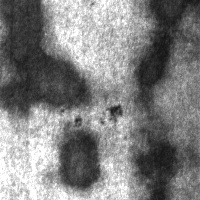

期待される答え: patches


In [ ]:
# 単一サンプルでのテスト推論
sample_idx = 11

sample = ds_test.iloc[sample_idx]
sample_question = sample["question"]
sample_image = sample["image"]
sample_answer = sample["answer"]

print(f"📷 サンプル #{sample_idx} のテスト推論")
print(f"{'─' * 50}")
print(f"質問: {sample_question}")
display(sample_image)
print(f"期待される答え: {sample_answer}")

In [ ]:
from PIL import Image as PILImage


def classify_image(
    image: PILImage.Image,
    question: str,
    deployment: str,
    *,
    quality: int = 50,
    temperature: float = 0.0,
    max_retries: int = 3,
    retry_wait: int = 10,
) -> str:
    """
    画像分類モデルを呼び出して分類結果を取得する。

    Args:
        image: 分類対象の画像
        question: 分類に関する質問
        deployment: 使用するモデルデプロイメント名
        quality: 画像エンコード品質 (1-100)
        temperature: 生成温度 (0.0 = 決定論的)
        max_retries: 最大リトライ回数
        retry_wait: リトライ間隔（秒）

    Returns:
        モデルからの分類結果
    """

    @retry(stop=stop_after_attempt(max_retries), wait=wait_fixed(retry_wait))
    def _call_api() -> str:
        encoded_image_url = f"data:image/jpeg;base64,{encode_image(image, quality=quality)}"

        response = client.chat.completions.create(
            model=deployment,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": question},
                        {"type": "image_url", "image_url": {"url": encoded_image_url}},
                    ],
                },
            ],
            temperature=temperature,
        )
        return response.choices[0].message.content

    return _call_api()


def evaluate_dataset(
    df: pd.DataFrame,
    deployment: str,
    result_column: str,
    *,
    image_col: str = "image",
    question_col: str = "question",
) -> pd.DataFrame:
    """
    データセット全体でモデルを評価する。

    Args:
        df: 評価対象のデータフレーム
        deployment: 使用するモデルデプロイメント名
        result_column: 結果を格納するカラム名
        image_col: 画像カラム名
        question_col: 質問カラム名

    Returns:
        結果カラムが追加されたデータフレーム
    """
    print(f"🔄 評価開始: {deployment}")
    print(f"   サンプル数: {len(df)}")
    start_time = time.time()

    df[result_column] = df.apply(
        lambda row: classify_image(row[image_col], row[question_col], deployment=deployment),
        axis=1,
    )

    elapsed = time.time() - start_time
    minutes, seconds = divmod(elapsed, 60)
    print(f"✅ 評価完了: {elapsed:.1f}秒 ({minutes:.0f}分 {seconds:.1f}秒)")
    return df


print("✅ 評価用関数を定義しました")

✅ 評価用関数を定義しました


In [ ]:
# ベースラインモデルでの推論
baseline_result = classify_image(
    sample_image, sample_question, deployment=eval_config.baseline_deployment
)
print(f"🔵 ベースラインモデル ({eval_config.baseline_deployment}): {baseline_result}")

# ファインチューニングモデルでの推論
ft_result = classify_image(
    sample_image, sample_question, deployment=eval_config.finetuned_deployment
)
print(f"🟢 ファインチューニングモデル ({eval_config.finetuned_deployment}): {ft_result}")

# 結果の比較
print(f"{'─' * 50}")
print(f"正解: {sample_answer}")
print(f"ベースライン: {'✅ 正解' if baseline_result == sample_answer else '❌ 不正解'}")
print(f"ファインチューニング: {'✅ 正解' if ft_result == sample_answer else '❌ 不正解'}")

🔵 ベースラインモデル (gpt-4.1): pitted_surface
🟢 ファインチューニングモデル (steel-surface-defects-gpt41): patches
──────────────────────────────────────────────────
正解: patches
ベースライン: ❌ 不正解
ファインチューニング: ✅ 正解
🟢 ファインチューニングモデル (steel-surface-defects-gpt41): patches
──────────────────────────────────────────────────
正解: patches
ベースライン: ❌ 不正解
ファインチューニング: ✅ 正解


### 6.2 ベースモデルの評価

テストデータセット全体でベースラインモデル（ファインチューニングなし）の評価を行います。

In [ ]:
# ベースラインモデルでテストデータセット全体を評価
ds_test = evaluate_dataset(
    ds_test,
    deployment=eval_config.baseline_deployment,
    result_column="baseline_pred",
)

🔄 評価開始: gpt-4.1
   サンプル数: 58
✅ 評価完了: 70.8秒 (1分 10.8秒)
✅ 評価完了: 70.8秒 (1分 10.8秒)


In [ ]:
ds_test

### 6.3 ファインチューニングモデルの評価

テストデータセット全体でファインチューニングモデルの評価を行います。

In [ ]:
# ファインチューニングモデルでテストデータセット全体を評価
ds_test = evaluate_dataset(
    ds_test,
    deployment=eval_config.finetuned_deployment,
    result_column="finetuned_pred",
)

🔄 評価開始: steel-surface-defects-gpt41
   サンプル数: 58
✅ 評価完了: 68.1秒 (1分 8.1秒)
✅ 評価完了: 68.1秒 (1分 8.1秒)


In [ ]:
ds_test

### 6.4 結果のエクスポート

評価結果を CSV および Excel ファイルにエクスポートします。

In [ ]:
# 出力ファイルパスの設定
result_dir = Path("result")
result_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_base = f"evaluation_results_{project_name}_{timestamp}"
output_csv = result_dir / f"{output_base}.csv"
output_excel = result_dir / f"{output_base}.xlsx"

print(f"📁 出力ファイル:")
print(f"   CSV: {output_csv}")
print(f"   Excel: {output_excel}")

📁 出力ファイル:
   CSV: evaluation_results_steel-surface-defects-gpt41_2025-12-02_23-35-14.csv
   Excel: evaluation_results_steel-surface-defects-gpt41_2025-12-02_23-35-14.xlsx


In [ ]:
# CSVエクスポート（画像列を除外）
export_columns = [col for col in ds_test.columns if col != "image"]
ds_test[export_columns].to_csv(output_csv, index=False)
print(f"✅ CSVファイルを保存しました: {output_csv} ({output_csv.stat().st_size / 1024:.1f} KB)")

✅ CSVファイルを保存しました: evaluation_results_steel-surface-defects-gpt41_2025-12-02_23-35-14.csv (13.2 KB)


In [ ]:
# Excelエクスポート（画像列を除外）
ds_test[export_columns].to_excel(output_excel, index=False)
print(
    f"✅ Excelファイルを保存しました: {output_excel} ({output_excel.stat().st_size / 1024:.1f} KB)"
)

✅ Excelファイルを保存しました: evaluation_results_steel-surface-defects-gpt41_2025-12-02_23-35-14.xlsx (6.6 KB)


### 6.5 ベースラインモデルの混同行列

ファインチューニングなしのベースラインモデルによる分類結果を可視化します。

In [ ]:
def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    title: str,
    save_path: str | Path | None = None,
    figsize: tuple[int, int] = (10, 10),
) -> tuple[np.ndarray, float]:
    """
    混同行列を描画し、精度を計算する。

    Args:
        y_true: 正解ラベル
        y_pred: 予測ラベル
        title: グラフのタイトル
        save_path: 保存先パス（Noneの場合は保存しない）
        figsize: 図のサイズ

    Returns:
        (混同行列, 精度)
    """
    labels = np.unique(np.concatenate([y_true, y_pred]))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    accuracy = np.trace(cm) / np.sum(cm)

    # 描画
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

    # セル内の数値を見やすく
    for (i, j), value in np.ndenumerate(cm):
        color = "white" if cm[i, j] > cm.max() / 2 else "orange"
        ax.text(j, i, f"{value}", ha="center", va="center", fontsize=10, color=color)

    ax.set_title(f"{title}\n(精度: {accuracy * 100:.1f}%)", fontsize=14, pad=20)
    ax.set_xlabel("予測クラス", fontsize=12, labelpad=10)
    ax.set_ylabel("実際のクラス", fontsize=12, labelpad=10)
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.grid(which="minor", color="gray", linestyle="--", linewidth=0.5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"📊 混同行列を保存しました: {save_path}")

    plt.show()
    return cm, accuracy


def print_evaluation_summary(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    model_name: str,
) -> None:
    """評価サマリーを出力する。"""
    labels = np.unique(np.concatenate([y_true, y_pred]))
    print(f"\n{'=' * 60}")
    print(f"📋 {model_name} の分類レポート")
    print(f"{'=' * 60}")
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

In [ ]:
# 結果保存用ディレクトリの作成
result_dir = Path("result")
result_dir.mkdir(exist_ok=True)
print(f"📁 結果保存先: {result_dir.absolute()}")

📊 混同行列を保存しました: confusion_matrix_baseline_steel-surface-defects-gpt41.png


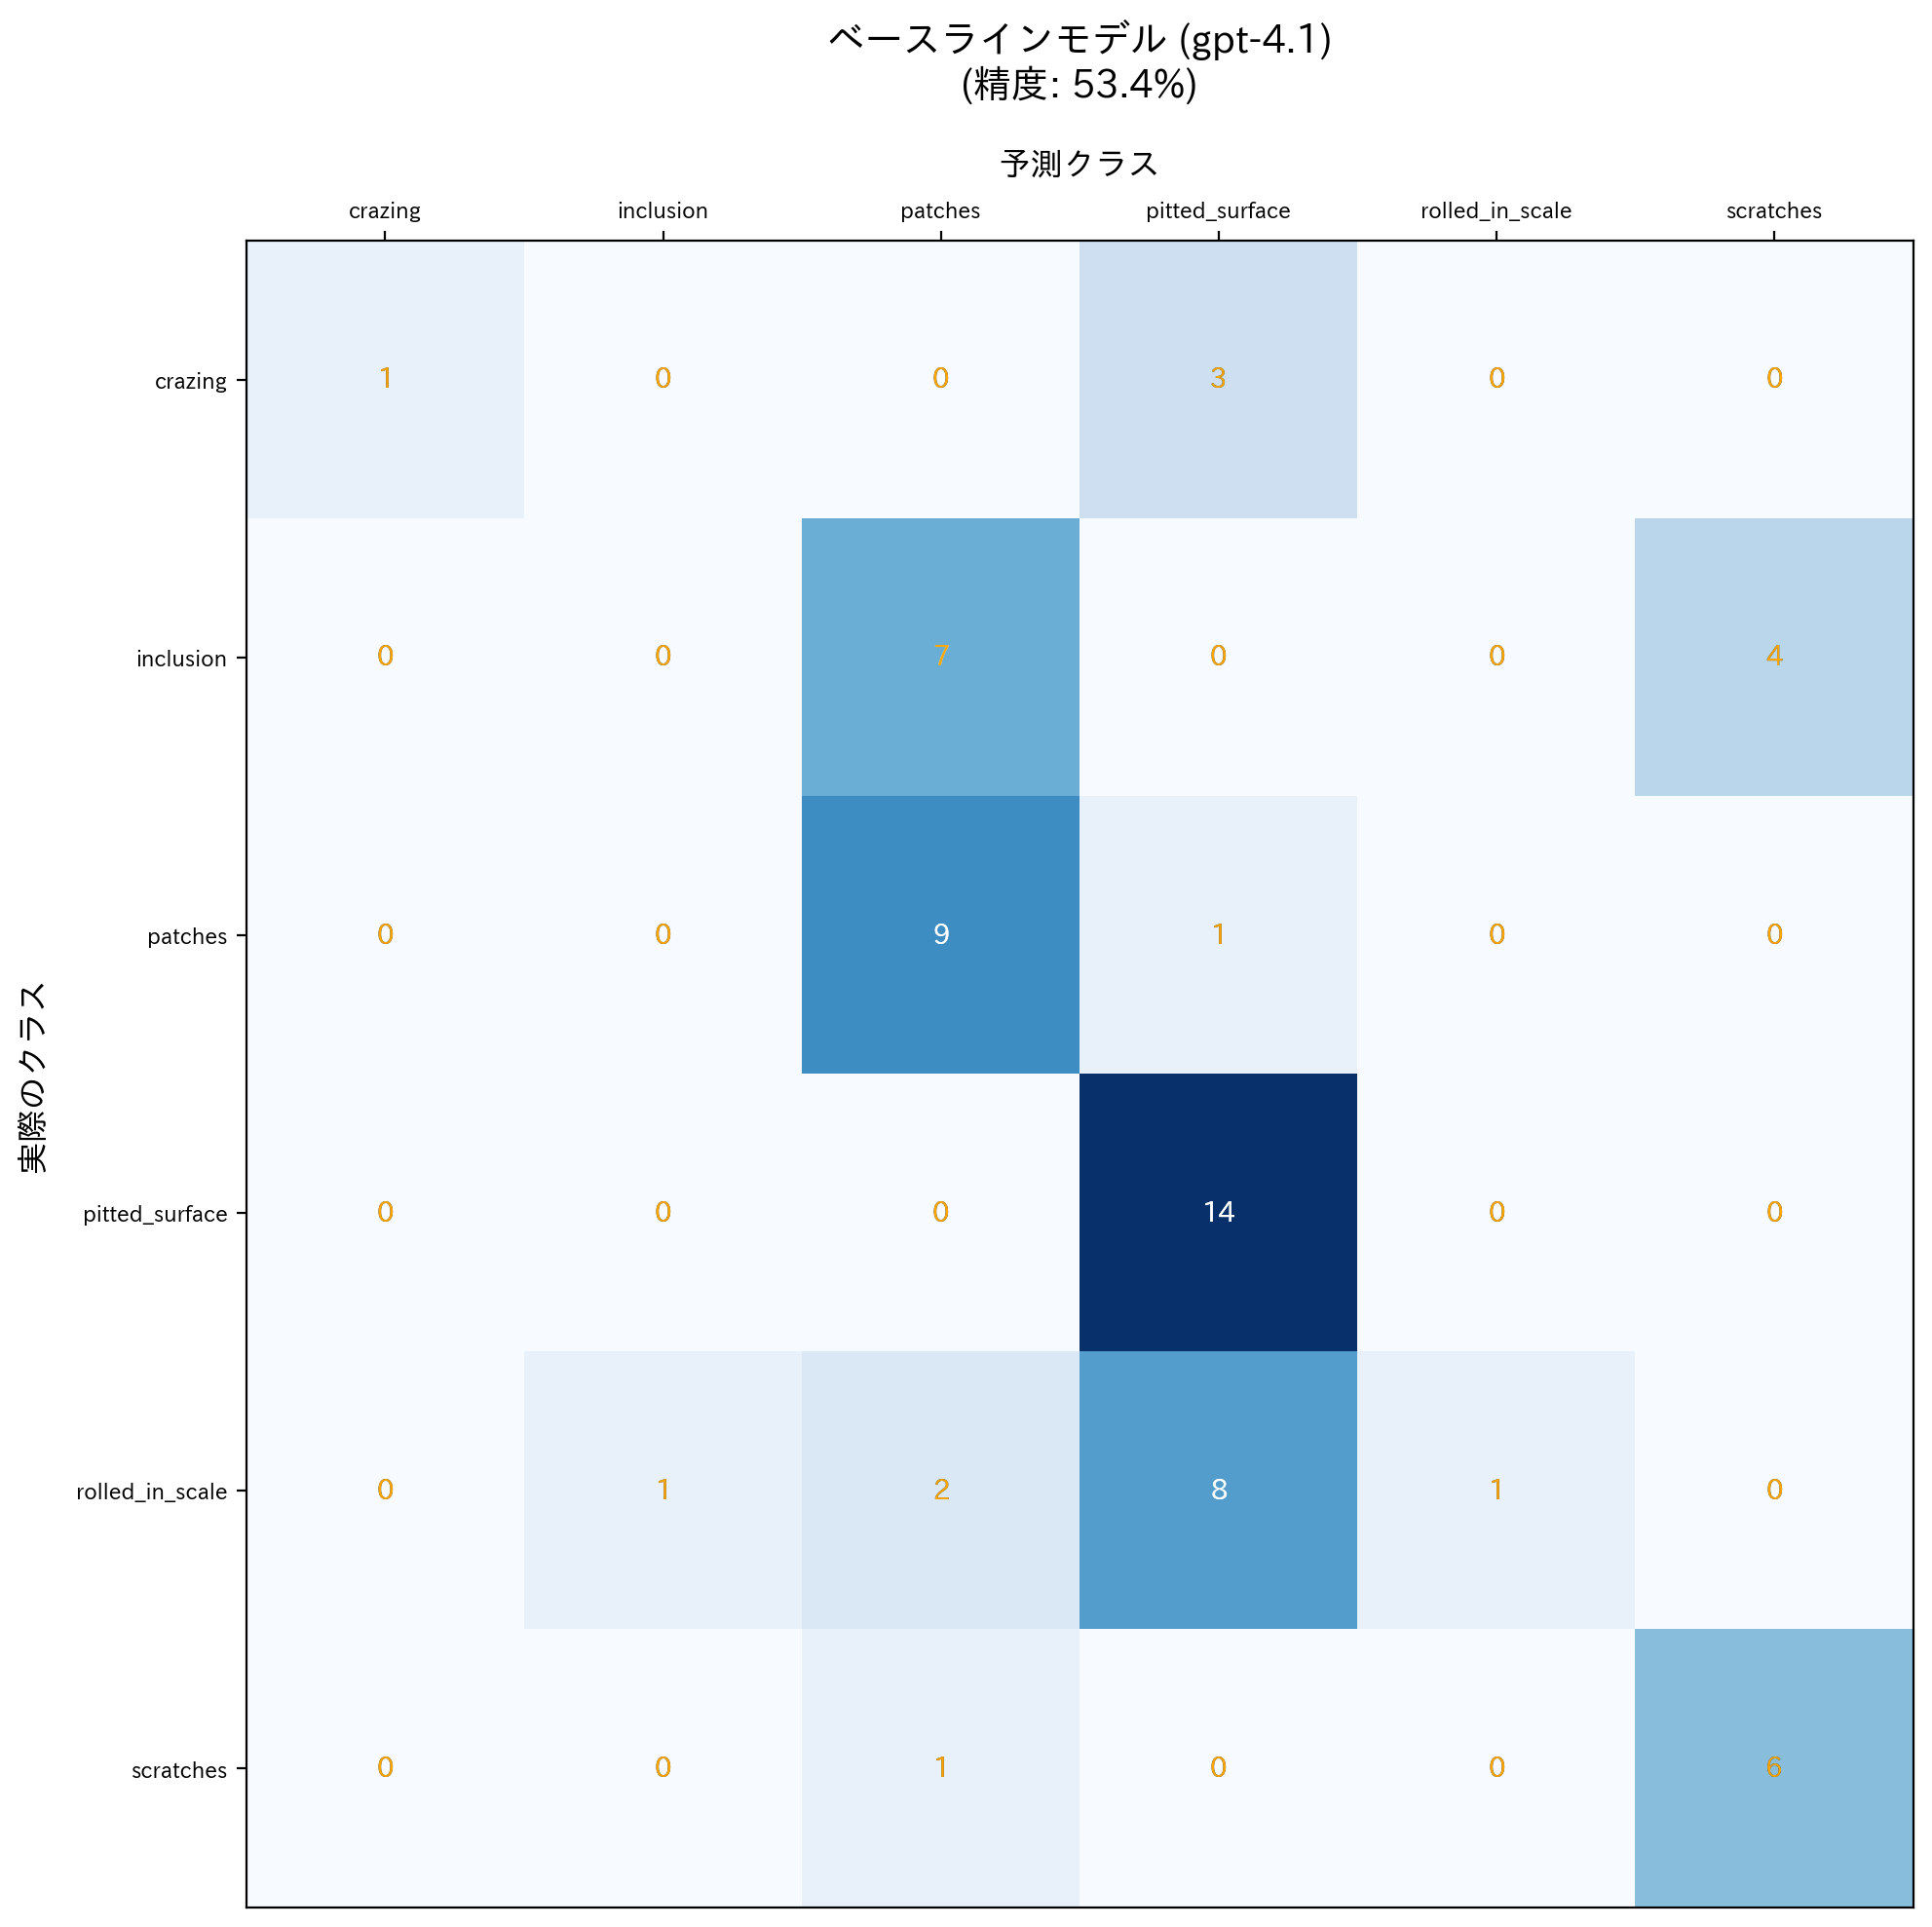

In [ ]:
# ベースラインモデルの混同行列
y_true_baseline = ds_test["answer"].to_numpy()
y_pred_baseline = ds_test["baseline_pred"].to_numpy()

cm_baseline, accuracy_baseline = plot_confusion_matrix(
    y_true_baseline,
    y_pred_baseline,
    title=f"ベースラインモデル ({eval_config.baseline_deployment})",
    save_path=result_dir / f"confusion_matrix_baseline_{project_name}.png",
)

In [ ]:
# ベースラインモデルの分類レポート
print_evaluation_summary(
    y_true_baseline, y_pred_baseline, f"ベースライン ({eval_config.baseline_deployment})"
)


📋 ベースライン (gpt-4.1) の分類レポート
                 precision    recall  f1-score   support

        crazing       1.00      0.25      0.40         4
      inclusion       0.00      0.00      0.00        11
        patches       0.47      0.90      0.62        10
 pitted_surface       0.54      1.00      0.70        14
rolled_in_scale       1.00      0.08      0.15        12
      scratches       0.60      0.86      0.71         7

       accuracy                           0.53        58
      macro avg       0.60      0.52      0.43        58
   weighted avg       0.56      0.53      0.42        58



### 6.6 ファインチューニングモデルの混同行列

ファインチューニングモデルによる分類結果を可視化します。

📊 混同行列を保存しました: confusion_matrix_finetuned_steel-surface-defects-gpt41.png


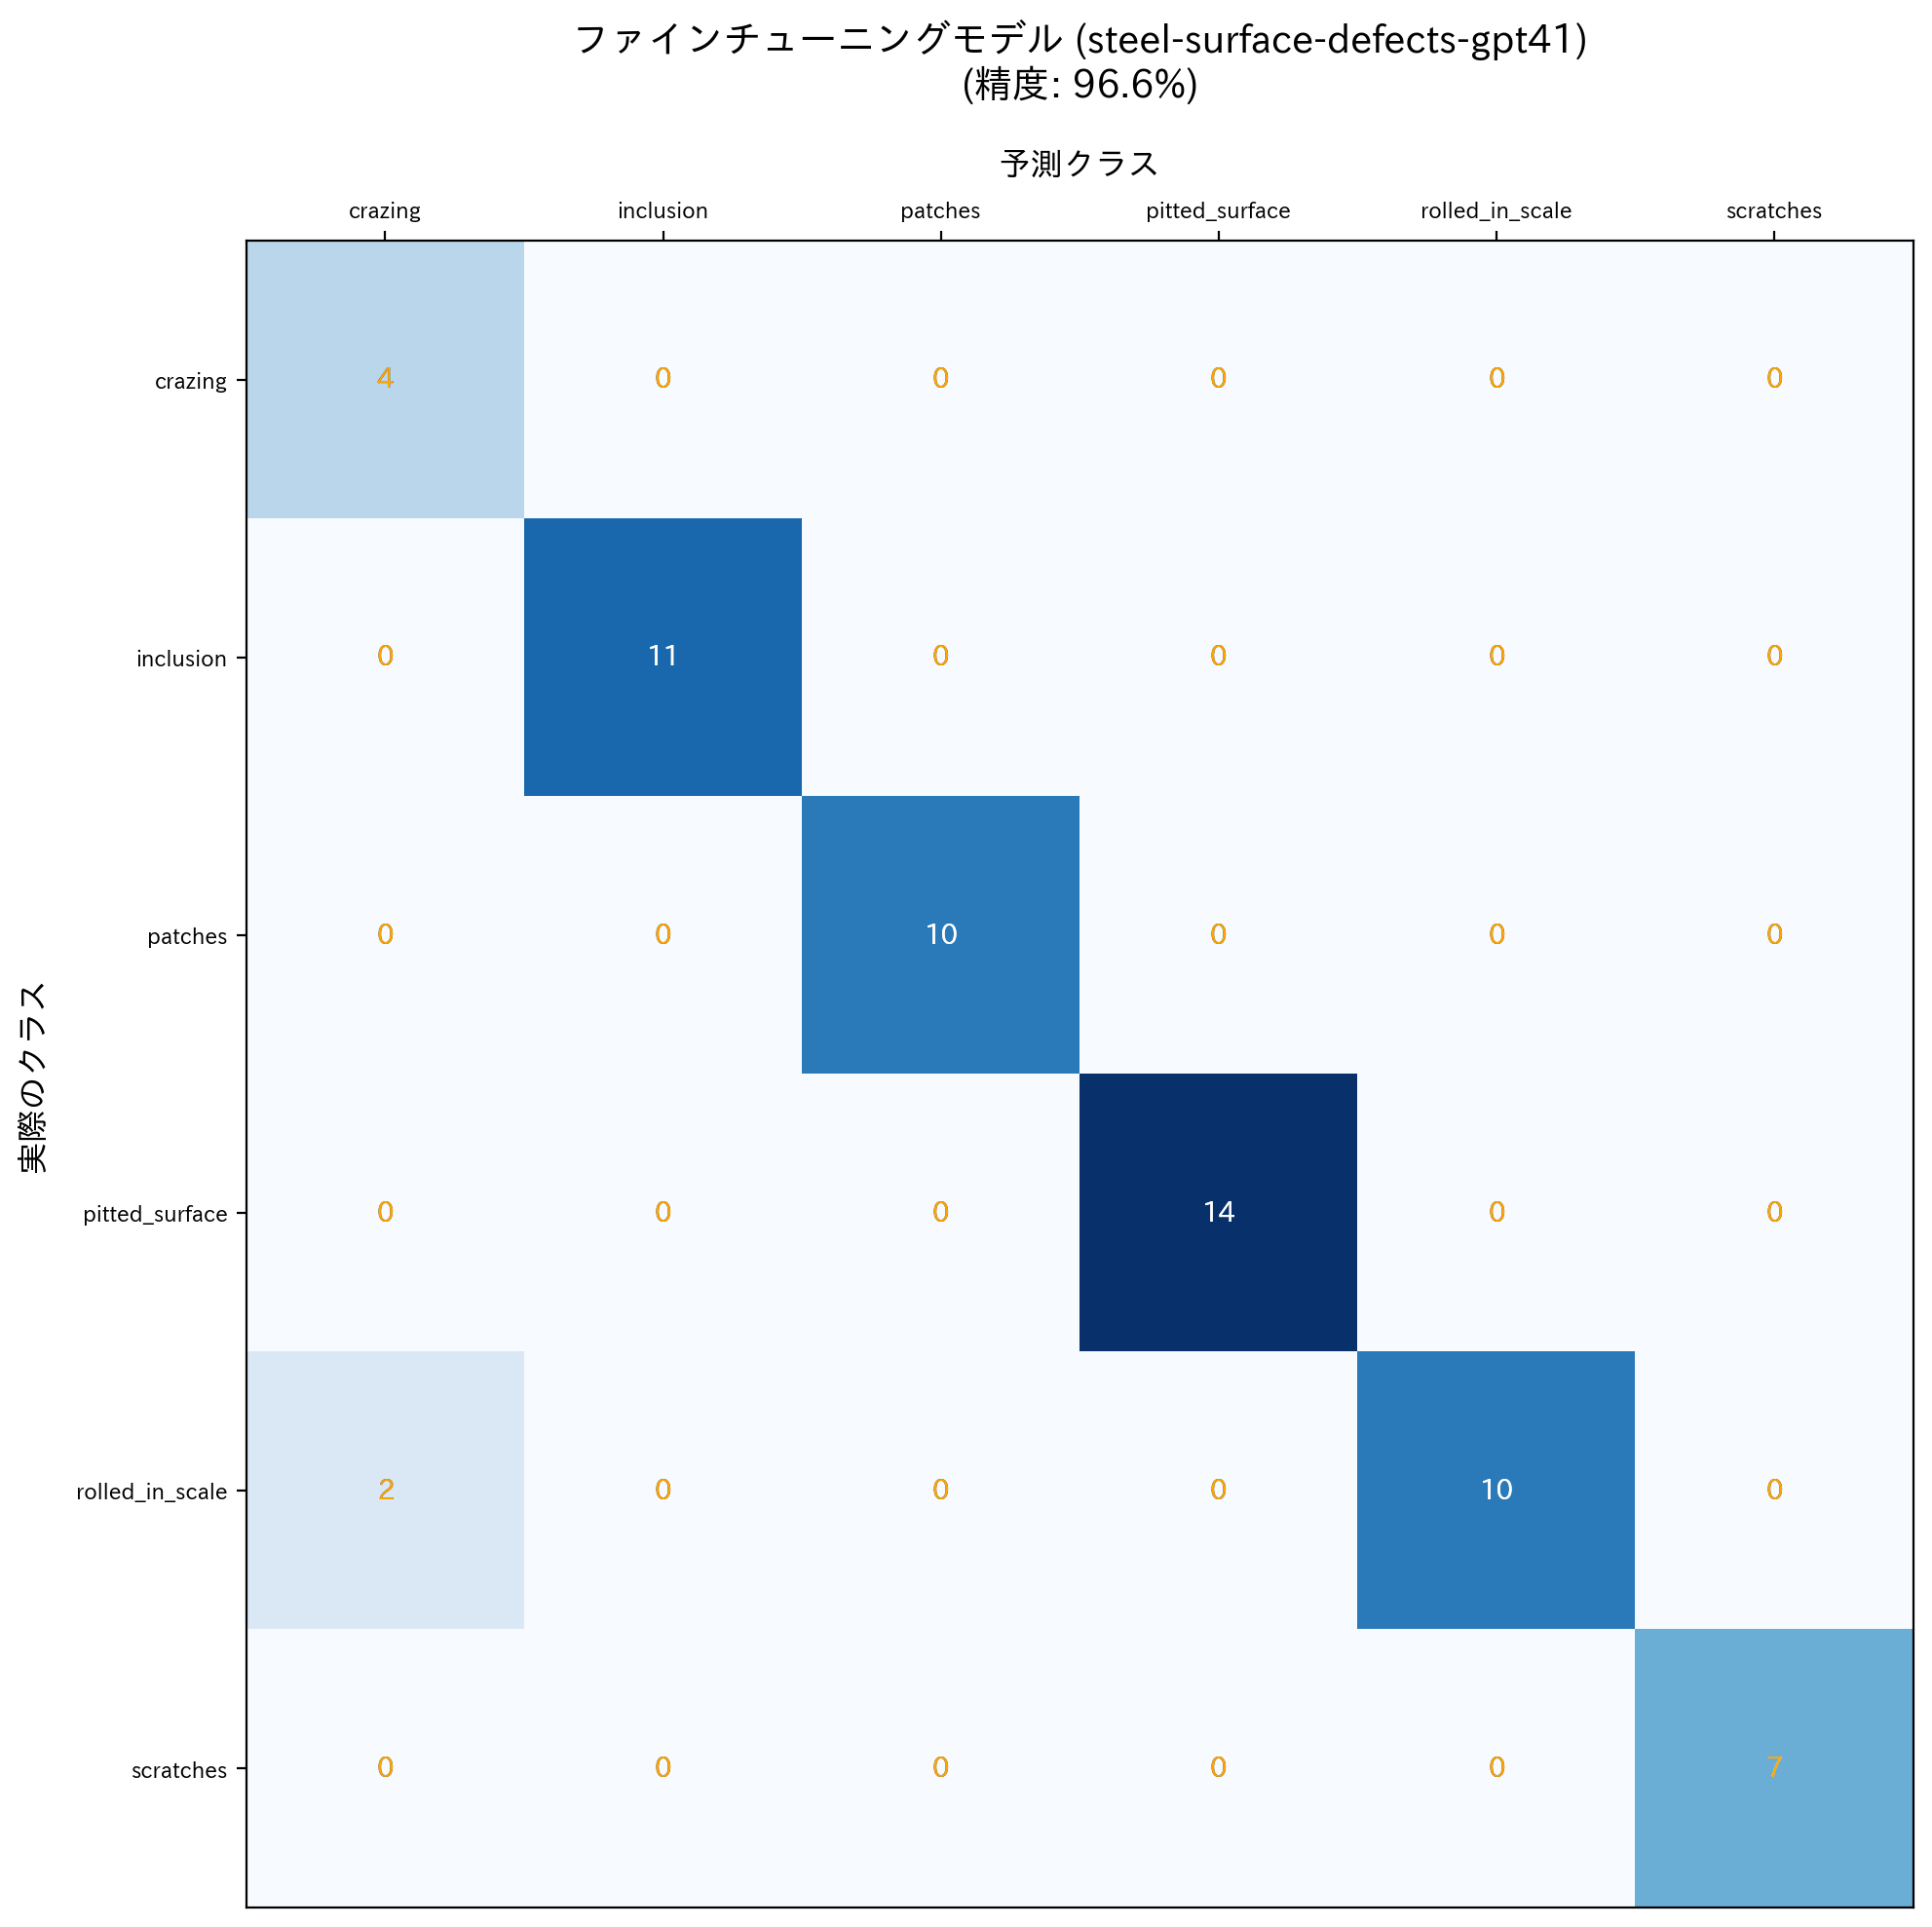

In [ ]:
# ファインチューニングモデルの混同行列
y_true_ft = ds_test["answer"].to_numpy()
y_pred_ft = ds_test["finetuned_pred"].to_numpy()

cm_ft, accuracy_ft = plot_confusion_matrix(
    y_true_ft,
    y_pred_ft,
    title=f"ファインチューニングモデル ({eval_config.finetuned_deployment})",
    save_path=result_dir / f"confusion_matrix_finetuned_{project_name}.png",
)

In [ ]:
# ファインチューニングモデルの分類レポート
print_evaluation_summary(
    y_true_ft, y_pred_ft, f"ファインチューニング ({eval_config.finetuned_deployment})"
)


📋 ファインチューニング (steel-surface-defects-gpt41) の分類レポート
                 precision    recall  f1-score   support

        crazing       0.67      1.00      0.80         4
      inclusion       1.00      1.00      1.00        11
        patches       1.00      1.00      1.00        10
 pitted_surface       1.00      1.00      1.00        14
rolled_in_scale       1.00      0.83      0.91        12
      scratches       1.00      1.00      1.00         7

       accuracy                           0.97        58
      macro avg       0.94      0.97      0.95        58
   weighted avg       0.98      0.97      0.97        58



In [ ]:
# 評価結果サマリー
print(f"\n{'=' * 60}")
print("📊 評価結果サマリー")
print(f"{'=' * 60}")
print(f"テストサンプル数: {len(ds_test)}")
print(f"{'─' * 60}")
print(f"ベースラインモデル ({eval_config.baseline_deployment}):")
print(f"   精度: {accuracy_baseline * 100:.2f}%")
print(f"{'─' * 60}")
print(f"ファインチューニングモデル ({eval_config.finetuned_deployment}):")
print(f"   精度: {accuracy_ft * 100:.2f}%")
print(f"{'─' * 60}")

improvement = (accuracy_ft - accuracy_baseline) * 100
if improvement > 0:
    print(f"🎉 ファインチューニングによる精度向上: +{improvement:.2f}%")
elif improvement < 0:
    print(f"⚠️ ファインチューニング後の精度低下: {improvement:.2f}%")
else:
    print(f"精度変化なし")


📊 評価結果サマリー
テストサンプル数: 58
────────────────────────────────────────────────────────────
ベースラインモデル (gpt-4.1):
   精度: 53.45%
────────────────────────────────────────────────────────────
ファインチューニングモデル (steel-surface-defects-gpt41):
   精度: 96.55%
────────────────────────────────────────────────────────────
🎉 ファインチューニングによる精度向上: +43.10%


## 7 結論と可視化

保存した評価結果CSVファイルを読み込み、ベースラインモデルとファインチューニングモデルの性能を比較します。

In [ ]:
# 評価結果CSVファイルの読み込み
import glob
from pathlib import Path


def find_latest_evaluation_csv(
    pattern: str = "evaluation_results_*.csv", base_dir: Path = Path("result")
) -> Path | None:
    """最新の評価結果CSVファイルを検索する。"""
    csv_files = list(base_dir.glob(pattern))
    if not csv_files:
        return None
    # ファイル名でソートして最新のものを返す
    return sorted(csv_files)[-1]


def load_evaluation_results(csv_path: Path | str | None = None) -> pd.DataFrame:
    """
    評価結果CSVファイルを読み込む。

    Args:
        csv_path: CSVファイルパス。Noneの場合は最新のファイルを自動検索。

    Returns:
        評価結果のDataFrame
    """
    if csv_path is None:
        csv_path = find_latest_evaluation_csv()
        if csv_path is None:
            raise FileNotFoundError(
                "評価結果CSVファイルが見つかりません（resultフォルダを確認してください）"
            )

    csv_path = Path(csv_path)
    print(f"📂 評価結果を読み込んでいます: {csv_path}")

    df = pd.read_csv(csv_path)
    print(f"✅ 読み込み完了: {len(df)} レコード")
    print(f"   カラム: {list(df.columns)}")

    return df


# 評価結果の読み込み（最新のCSVファイルを自動検索）
# 特定のファイルを指定する場合は引数にパスを渡す
# 例: df_results = load_evaluation_results("result/evaluation_results_steel-surface-defects-gpt41_2024-12-03_10-30-00.csv")
df_results = load_evaluation_results()
df_results.head()

In [ ]:
# 精度の計算
def calculate_accuracy(df: pd.DataFrame, pred_col: str, answer_col: str = "answer") -> float:
    """予測カラムの精度を計算する。"""
    correct = (df[pred_col] == df[answer_col]).sum()
    return correct / len(df)


# ベースラインとファインチューニングの精度を計算
accuracy_baseline = calculate_accuracy(df_results, "baseline_pred")
accuracy_ft = calculate_accuracy(df_results, "finetuned_pred")


# 最終結果サマリー
def print_final_summary(
    baseline_accuracy: float,
    finetuned_accuracy: float,
    baseline_name: str = "ベースライン",
    finetuned_name: str = "ファインチューニング",
) -> None:
    """最終結果サマリーを出力する。"""
    improvement = (finetuned_accuracy - baseline_accuracy) * 100

    print("╔" + "═" * 58 + "╗")
    print("║" + " 🎯 評価結果サマリー".center(56) + "║")
    print("╠" + "═" * 58 + "╣")
    print(f"║  {baseline_name}:".ljust(40) + f"{baseline_accuracy * 100:6.2f}%  ║")
    print(f"║  {finetuned_name}:".ljust(40) + f"{finetuned_accuracy * 100:6.2f}%  ║")
    print("╠" + "═" * 58 + "╣")

    if improvement > 0:
        print(f"║  🎉 精度向上: +{improvement:.2f}%".ljust(59) + "║")
    elif improvement < 0:
        print(f"║  ⚠️ 精度低下: {improvement:.2f}%".ljust(59) + "║")
    else:
        print(f"║  ➡️ 精度変化なし".ljust(59) + "║")

    print("╚" + "═" * 58 + "╝")


print_final_summary(accuracy_baseline, accuracy_ft)

╔══════════════════════════════════════════════════════════╗
║                       🎯 評価結果サマリー                       ║
╠══════════════════════════════════════════════════════════╣
║  ベースライン:                               53.45%  ║
║  ファインチューニング:                           96.55%  ║
╠══════════════════════════════════════════════════════════╣
║  🎉 精度向上: +43.10%                                         ║
╚══════════════════════════════════════════════════════════╝


📊 ベースラインモデルの混同行列


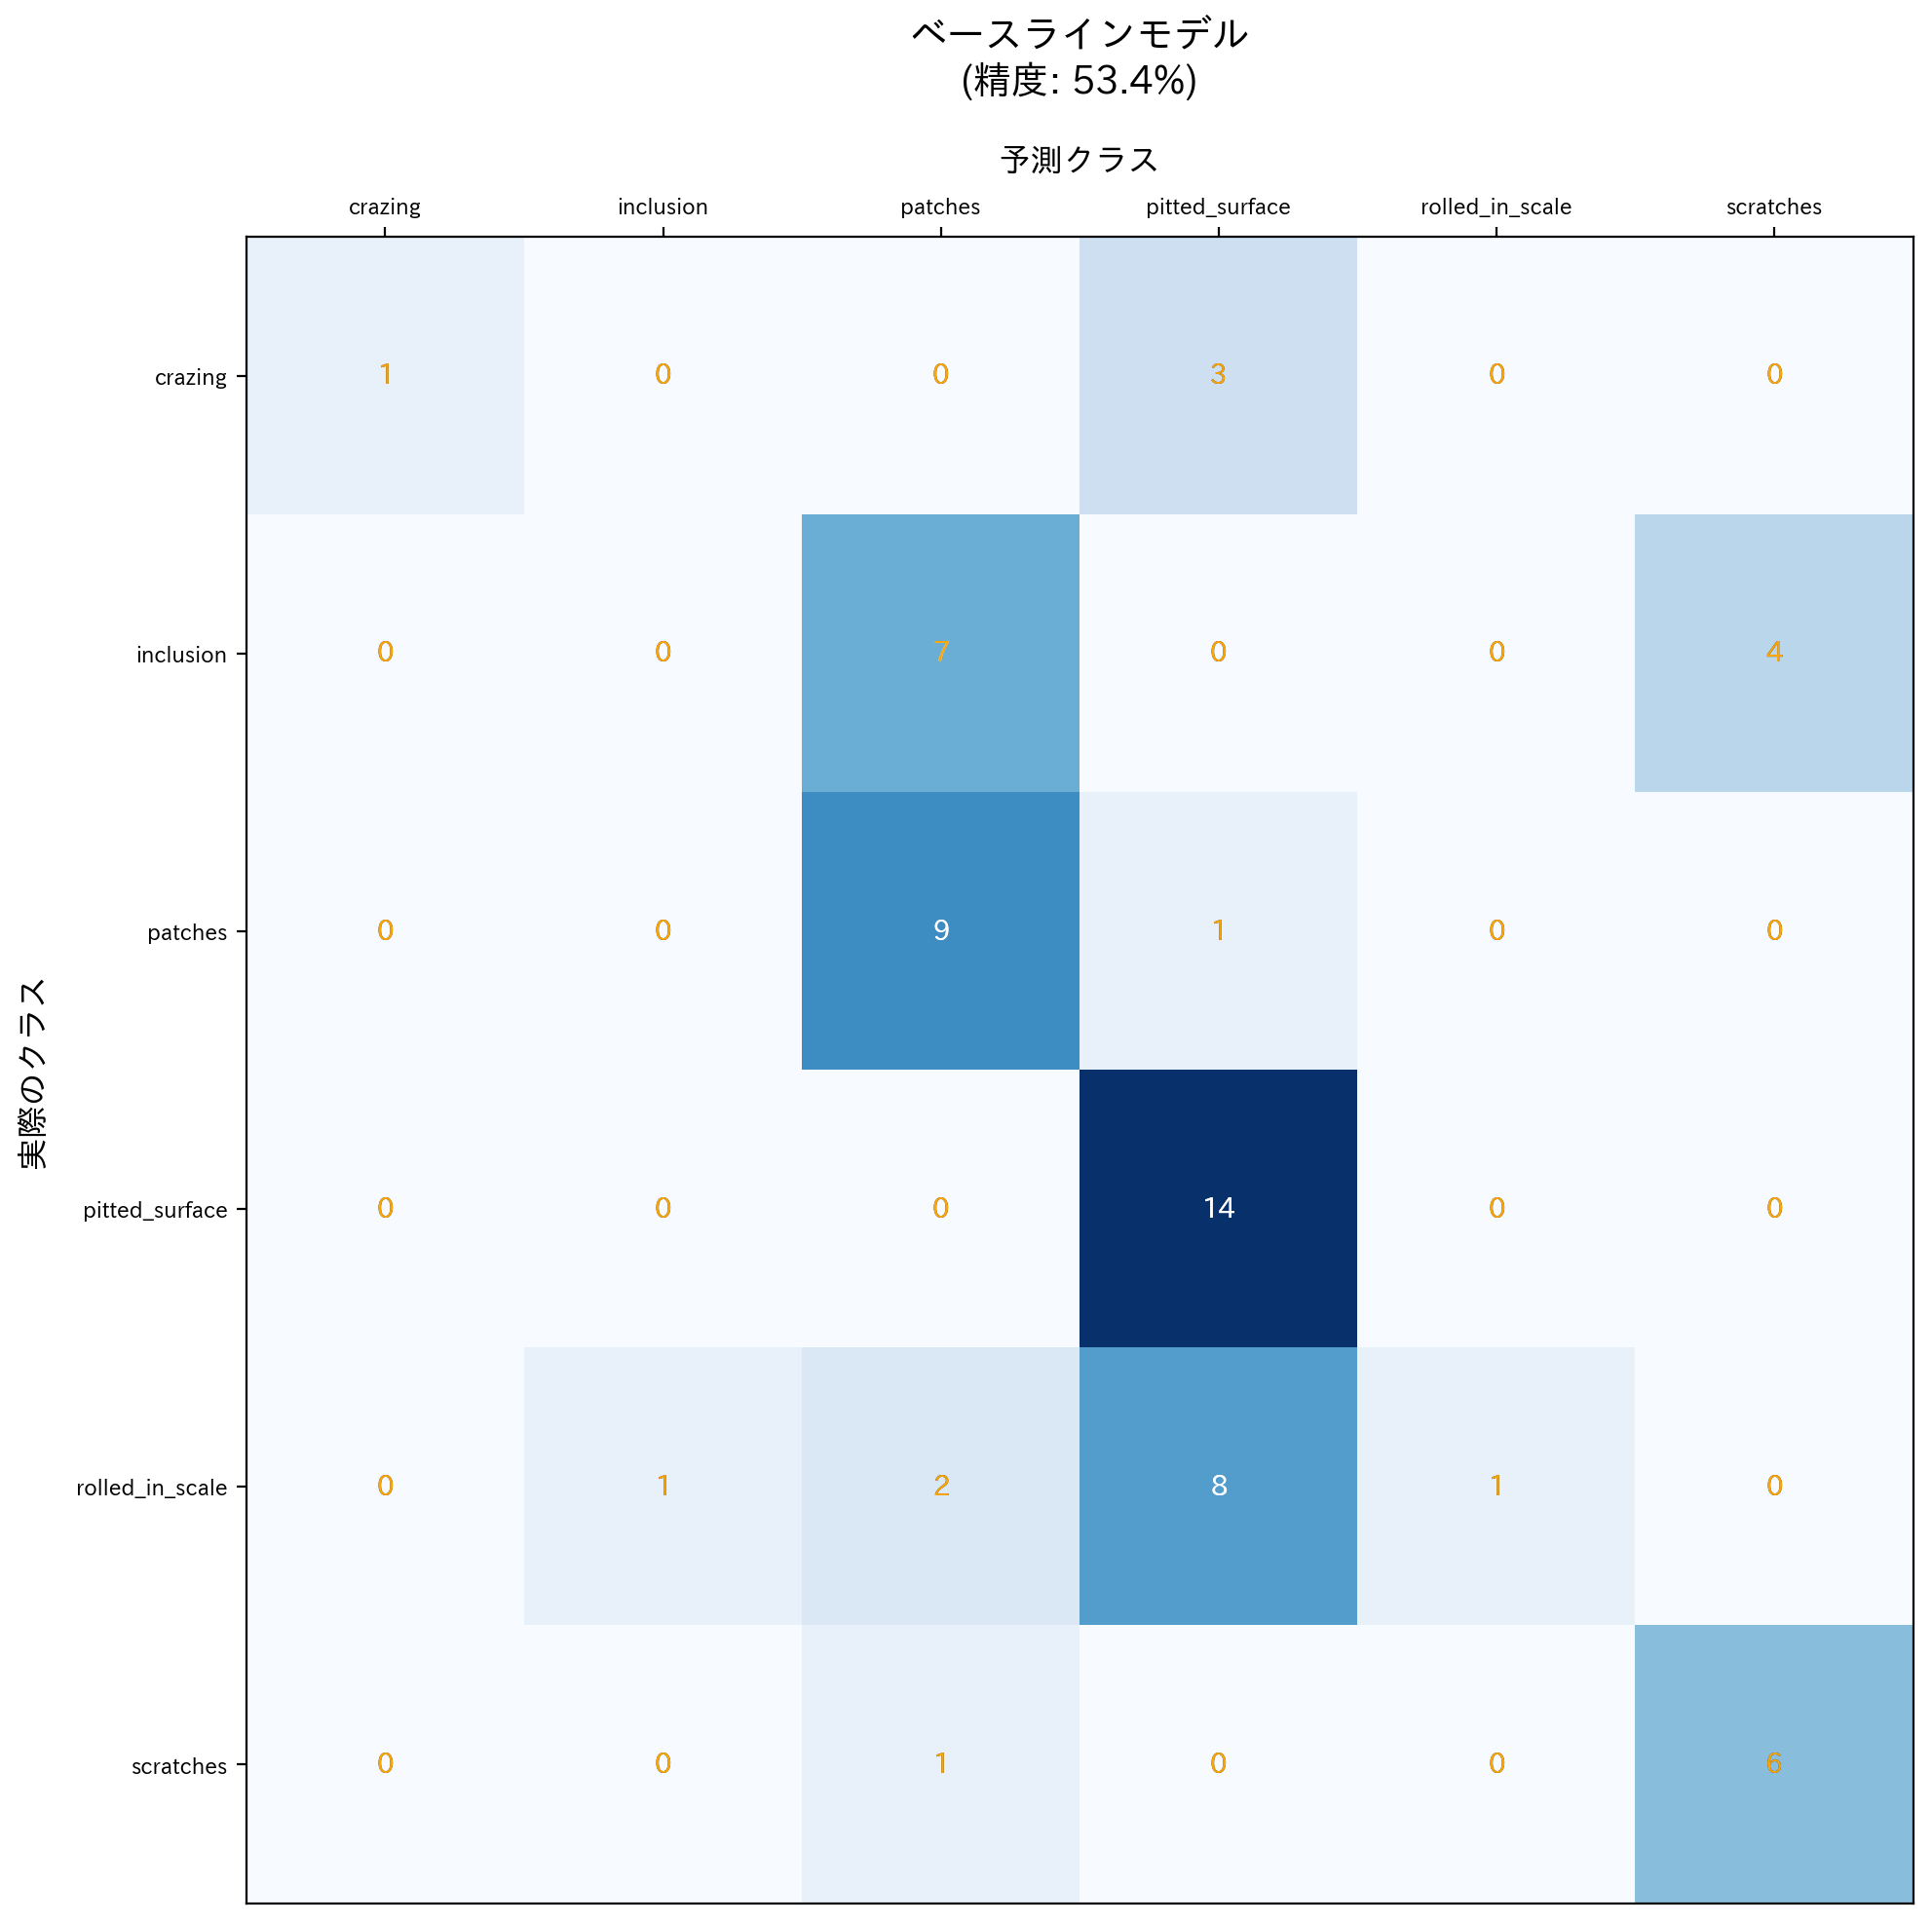

In [ ]:
# 混同行列の生成と表示
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix


def plot_confusion_matrix_from_df(
    df: pd.DataFrame,
    pred_col: str,
    answer_col: str = "answer",
    title: str = "混同行列",
    save_path: str | Path | None = None,
    figsize: tuple[int, int] = (10, 10),
) -> tuple[np.ndarray, float]:
    """
    DataFrameから混同行列を描画し、精度を計算する。
    """
    y_true = df[answer_col].to_numpy()
    y_pred = df[pred_col].to_numpy()
    labels = np.unique(np.concatenate([y_true, y_pred]))

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    accuracy = np.trace(cm) / np.sum(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

    for (i, j), value in np.ndenumerate(cm):
        color = "white" if cm[i, j] > cm.max() / 2 else "orange"
        ax.text(j, i, f"{value}", ha="center", va="center", fontsize=10, color=color)

    ax.set_title(f"{title}\n(精度: {accuracy * 100:.1f}%)", fontsize=14, pad=20)
    ax.set_xlabel("予測クラス", fontsize=12, labelpad=10)
    ax.set_ylabel("実際のクラス", fontsize=12, labelpad=10)
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.grid(which="minor", color="gray", linestyle="--", linewidth=0.5)
    plt.tight_layout()

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"📊 混同行列を保存しました: {save_path}")

    plt.show()
    return cm, accuracy


# resultフォルダの確保
result_dir = Path("result")
result_dir.mkdir(exist_ok=True)

# ベースラインモデルの混同行列
print("📊 ベースラインモデルの混同行列")
cm_baseline, _ = plot_confusion_matrix_from_df(
    df_results,
    pred_col="baseline_pred",
    title="ベースラインモデル",
    save_path=result_dir / f"confusion_matrix_baseline_{project_name}.png",
)

📊 ファインチューニングモデルの混同行列


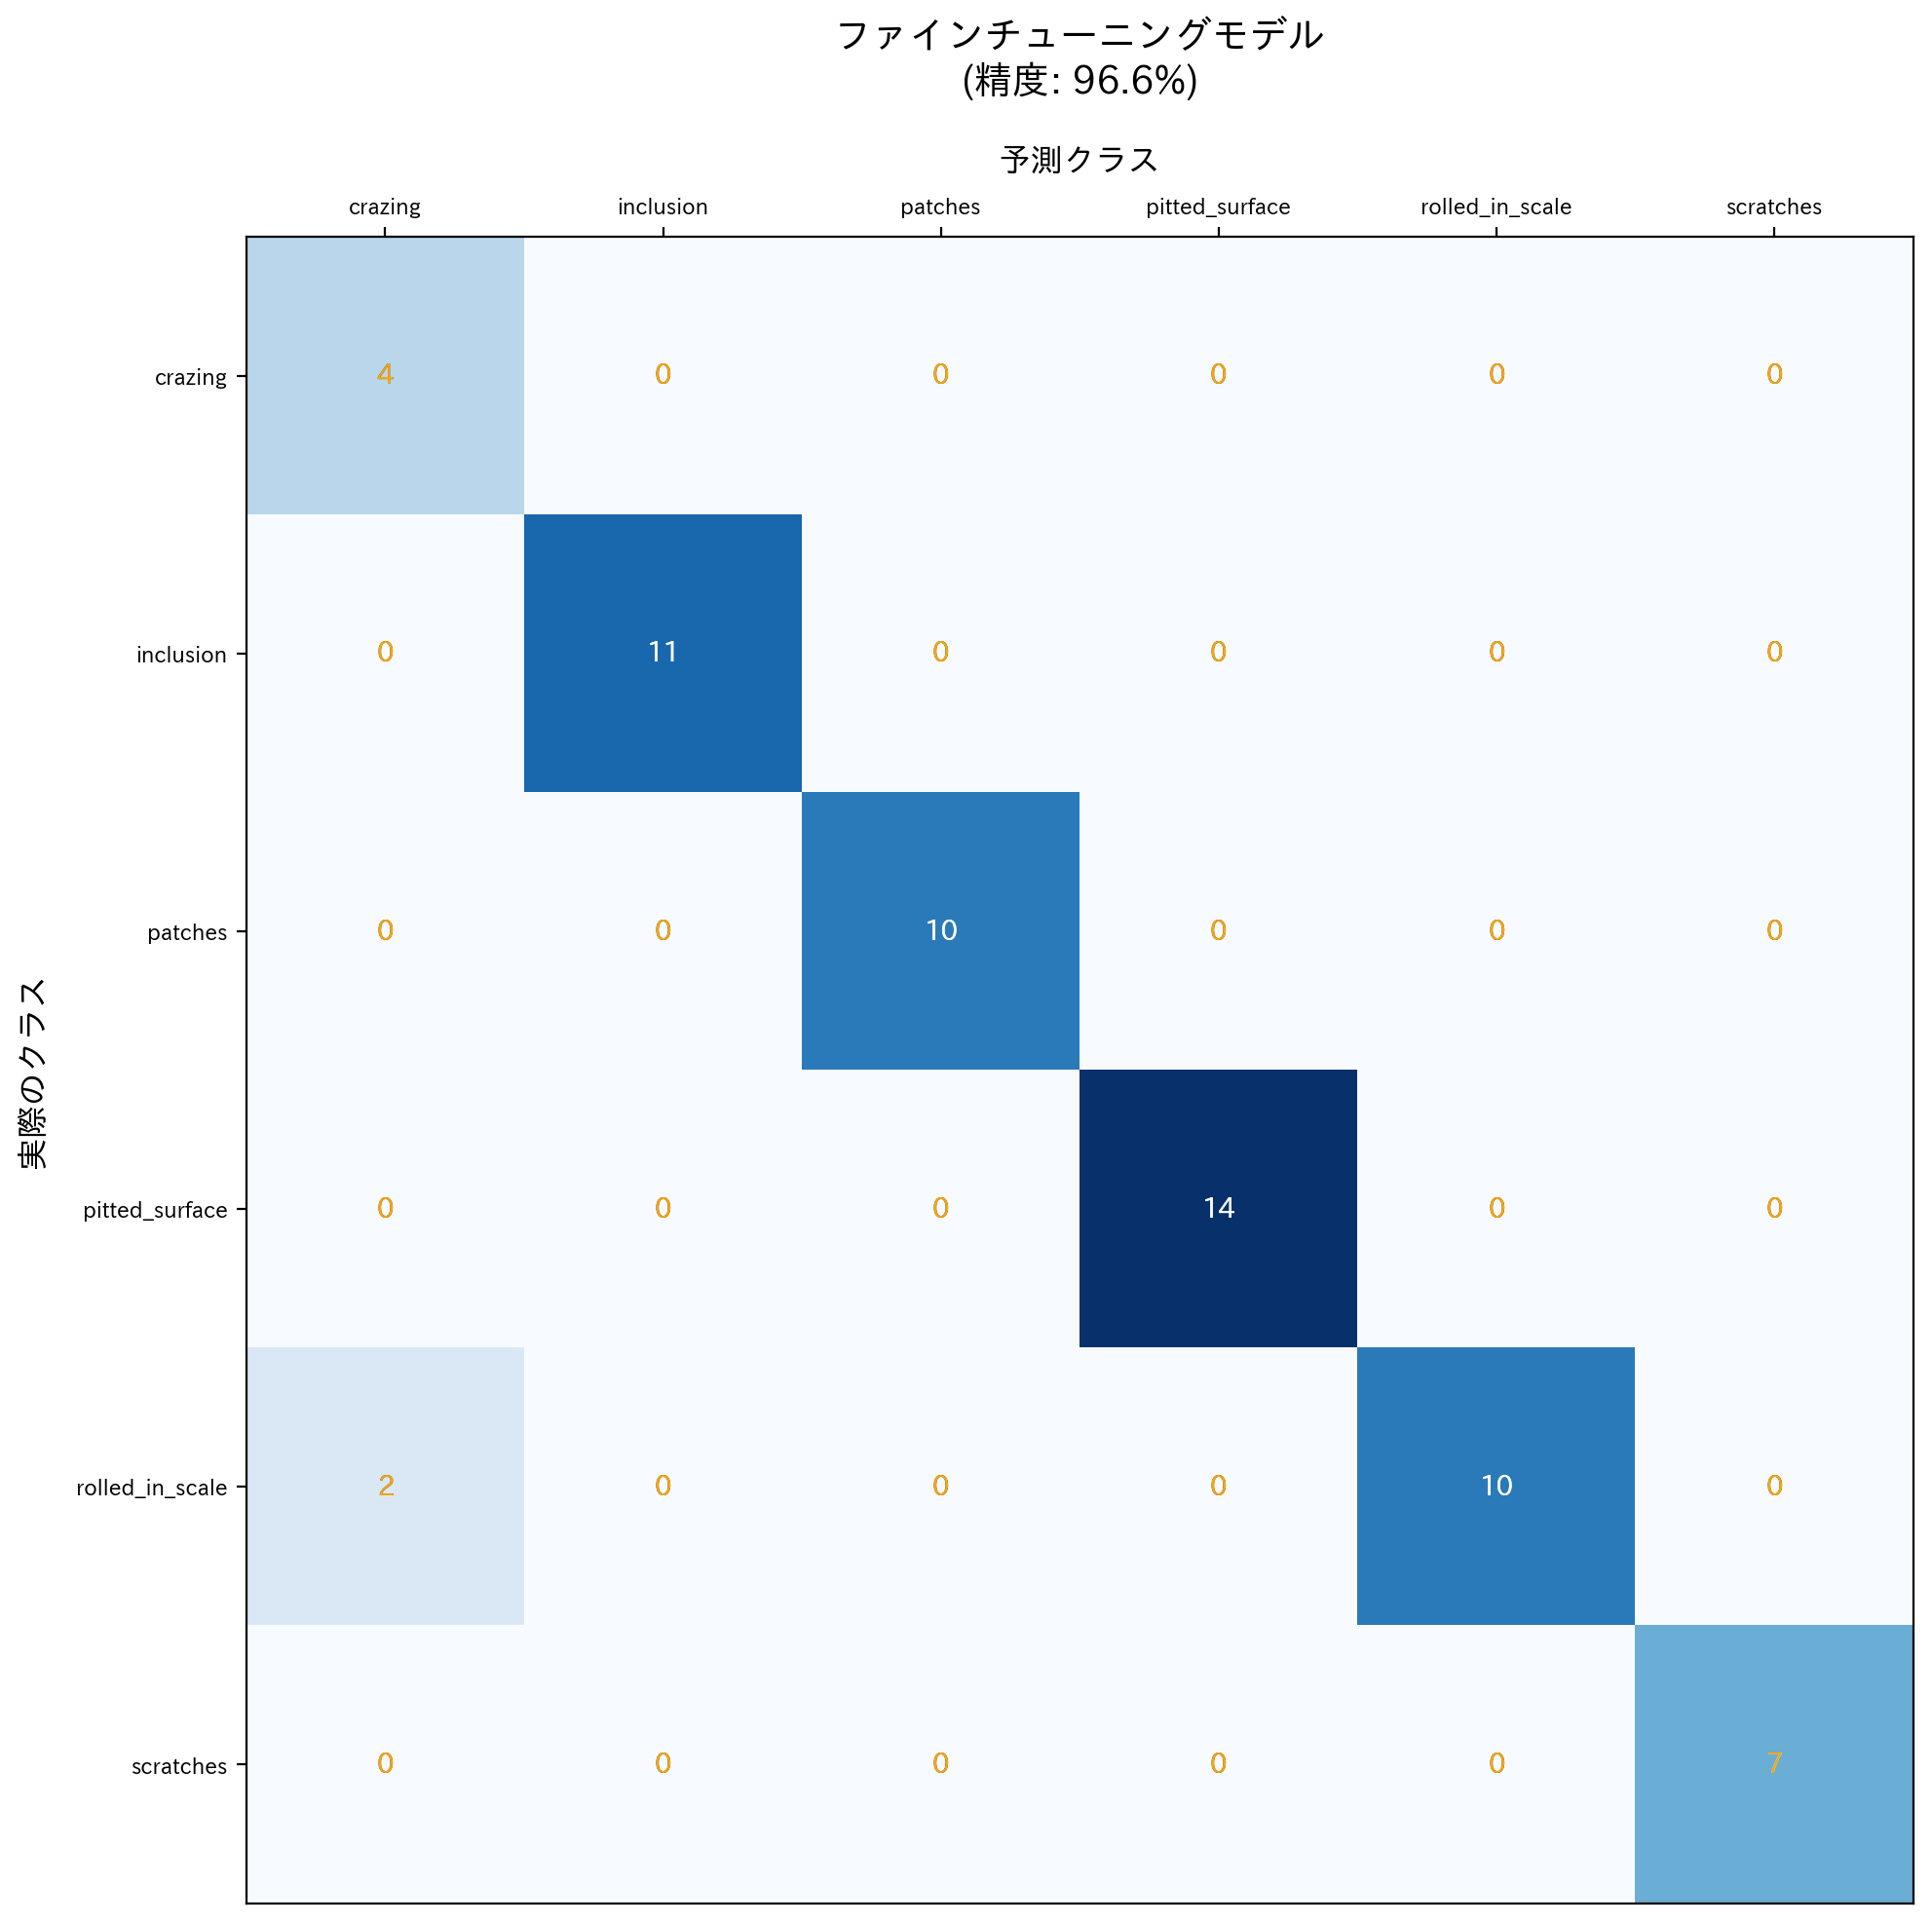

In [ ]:
# ファインチューニングモデルの混同行列
print("📊 ファインチューニングモデルの混同行列")
cm_ft, _ = plot_confusion_matrix_from_df(
    df_results,
    pred_col="finetuned_pred",
    title="ファインチューニングモデル",
    save_path=result_dir / f"confusion_matrix_finetuned_{project_name}.png",
)

In [ ]:
# 分類レポートの出力
def print_classification_reports(df: pd.DataFrame) -> None:
    """ベースラインとファインチューニングの分類レポートを出力する。"""
    y_true = df["answer"].to_numpy()
    labels = np.unique(y_true)

    print(f"\n{'=' * 60}")
    print("📋 ベースラインモデルの分類レポート")
    print(f"{'=' * 60}")
    y_pred_baseline = df["baseline_pred"].to_numpy()
    print(classification_report(y_true, y_pred_baseline, target_names=labels, zero_division=0))

    print(f"\n{'=' * 60}")
    print("📋 ファインチューニングモデルの分類レポート")
    print(f"{'=' * 60}")
    y_pred_ft = df["finetuned_pred"].to_numpy()
    print(classification_report(y_true, y_pred_ft, target_names=labels, zero_division=0))


print_classification_reports(df_results)


📋 ベースラインモデルの分類レポート
                 precision    recall  f1-score   support

        crazing       1.00      0.25      0.40         4
      inclusion       0.00      0.00      0.00        11
        patches       0.47      0.90      0.62        10
 pitted_surface       0.54      1.00      0.70        14
rolled_in_scale       1.00      0.08      0.15        12
      scratches       0.60      0.86      0.71         7

       accuracy                           0.53        58
      macro avg       0.60      0.52      0.43        58
   weighted avg       0.56      0.53      0.42        58


📋 ファインチューニングモデルの分類レポート
                 precision    recall  f1-score   support

        crazing       0.67      1.00      0.80         4
      inclusion       1.00      1.00      1.00        11
        patches       1.00      1.00      1.00        10
 pitted_surface       1.00      1.00      1.00        14
rolled_in_scale       1.00      0.83      0.91        12
      scratches       1.00      1.00    

In [ ]:
# 予測結果のサマリー表示
# 正誤判定カラムを追加
df_results["baseline_correct"] = df_results["answer"] == df_results["baseline_pred"]
df_results["finetuned_correct"] = df_results["answer"] == df_results["finetuned_pred"]

print(f"📊 予測結果サマリー:")
print(f"   総サンプル数: {len(df_results)}")
print(f"   ベースライン正解数: {df_results['baseline_correct'].sum()} / {len(df_results)}")
print(f"   ファインチューニング正解数: {df_results['finetuned_correct'].sum()} / {len(df_results)}")
print()

# 結果テーブルを表示
result_columns = [
    "image_file",
    "answer",
    "baseline_pred",
    "finetuned_pred",
    "baseline_correct",
    "finetuned_correct",
]
df_results[result_columns]

📋 誤分類分析
ベースラインでの誤分類数: 27
ファインチューニングで修正された数: 25 (92.6%)
────────────────────────────────────────────────────────────

以下、誤分類ケースを 5 件表示します:



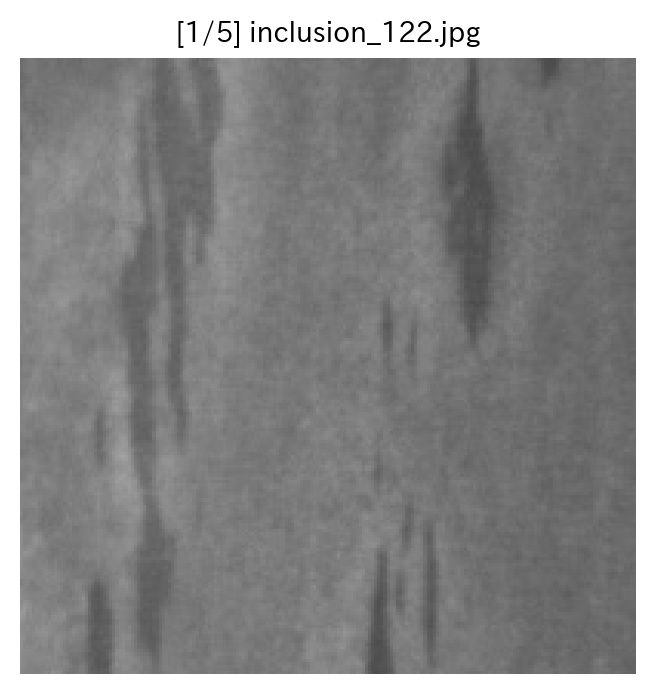

  正解ラベル: inclusion
  ベースライン予測: patches ❌ 不正解
  ファインチューニング予測: inclusion ✅ 正解
────────────────────────────────────────



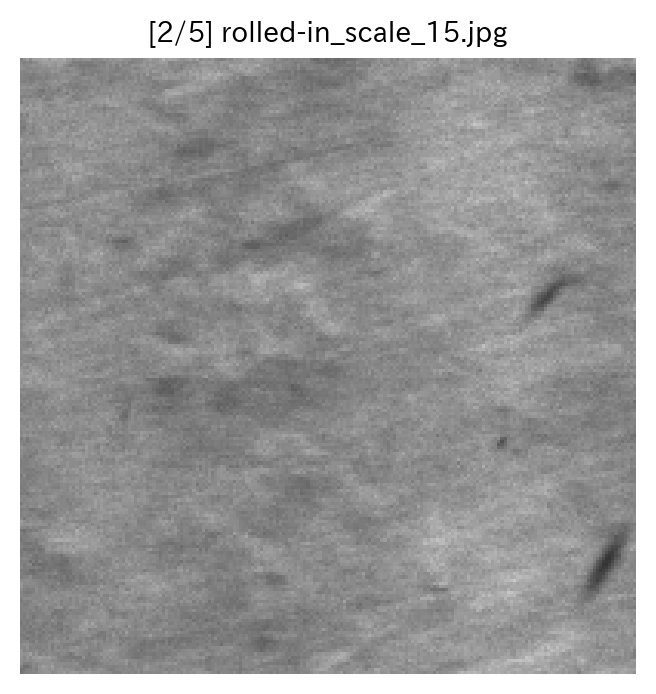

  正解ラベル: rolled_in_scale
  ベースライン予測: patches ❌ 不正解
  ファインチューニング予測: rolled_in_scale ✅ 正解
────────────────────────────────────────



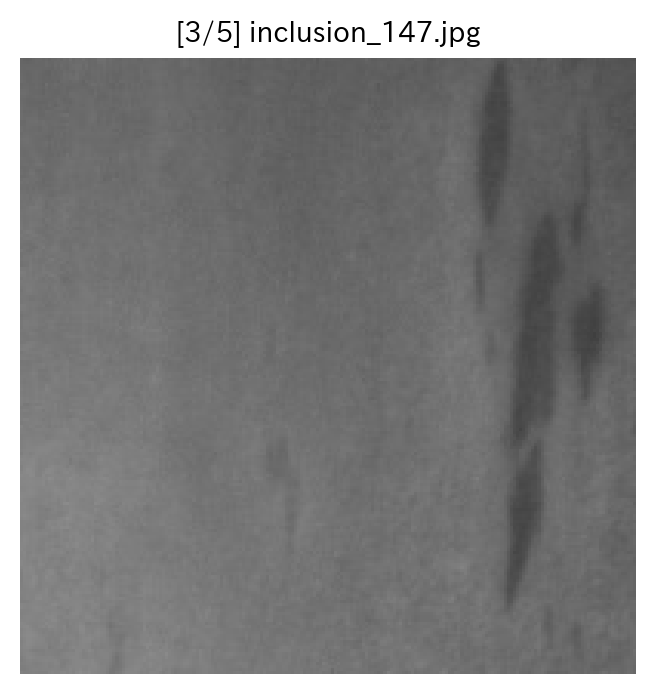

  正解ラベル: inclusion
  ベースライン予測: patches ❌ 不正解
  ファインチューニング予測: inclusion ✅ 正解
────────────────────────────────────────



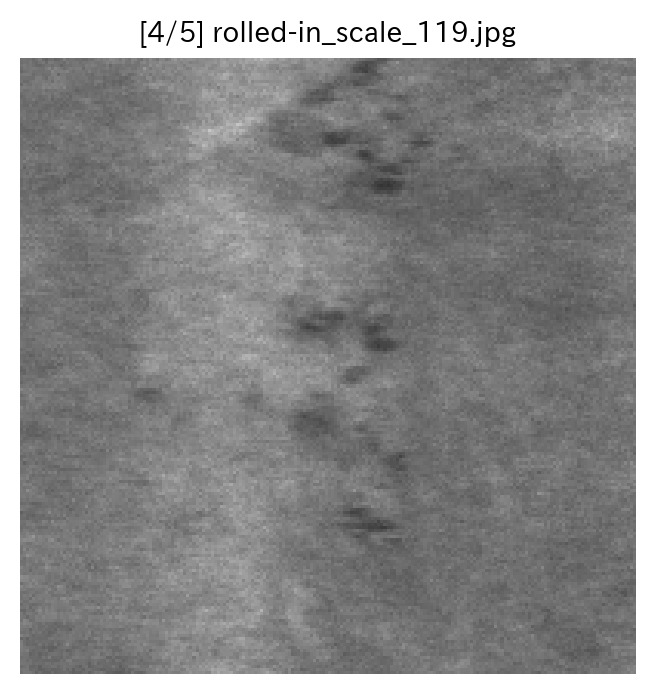

  正解ラベル: rolled_in_scale
  ベースライン予測: pitted_surface ❌ 不正解
  ファインチューニング予測: rolled_in_scale ✅ 正解
────────────────────────────────────────



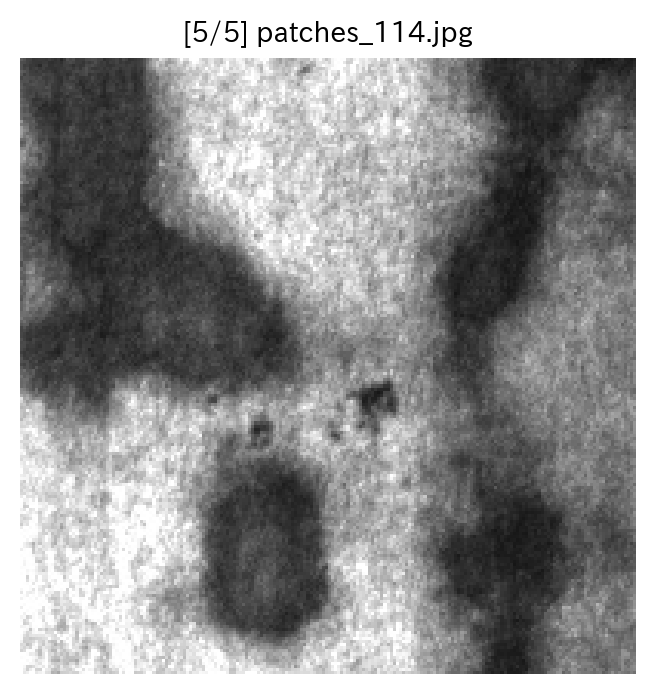

  正解ラベル: patches
  ベースライン予測: pitted_surface ❌ 不正解
  ファインチューニング予測: patches ✅ 正解
────────────────────────────────────────



In [ ]:
# 誤分類ケースの詳細分析
from PIL import Image


def analyze_misclassifications(
    df: pd.DataFrame,
    baseline_pred_col: str = "baseline_pred",
    finetuned_pred_col: str = "finetuned_pred",
    answer_col: str = "answer",
    image_file_col: str = "image_file",
    max_display: int = 5,
) -> None:
    """
    ベースラインモデルで誤分類されたケースを分析・表示する。

    Args:
        df: 評価結果を含むデータフレーム
        baseline_pred_col: ベースライン予測のカラム名
        finetuned_pred_col: ファインチューニング予測のカラム名
        answer_col: 正解ラベルのカラム名
        image_file_col: 画像ファイルパスのカラム名
        max_display: 表示する最大件数
    """
    # ベースラインで誤分類されたケースを抽出
    misclassified = df[df[answer_col] != df[baseline_pred_col]].copy()

    if len(misclassified) == 0:
        print("✅ ベースラインモデルでの誤分類ケースはありません")
        return

    # ファインチューニングで修正されたかどうか
    misclassified["fixed_by_ft"] = misclassified[answer_col] == misclassified[finetuned_pred_col]
    fixed_count = misclassified["fixed_by_ft"].sum()

    print(f"{'=' * 60}")
    print(f"📋 誤分類分析")
    print(f"{'=' * 60}")
    print(f"ベースラインでの誤分類数: {len(misclassified)}")
    print(
        f"ファインチューニングで修正された数: {fixed_count} ({fixed_count / len(misclassified) * 100:.1f}%)"
    )
    print(f"{'─' * 60}")

    # 表示件数を制限
    display_count = min(len(misclassified), max_display)
    print(f"\n以下、誤分類ケースを {display_count} 件表示します:\n")

    for idx, (_, row) in enumerate(misclassified.head(max_display).iterrows()):
        image_path = Path(row[image_file_col])

        # 画像を表示
        if image_path.exists():
            img = Image.open(image_path)
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.title(f"[{idx + 1}/{display_count}] {image_path.name}", fontsize=10)
            plt.axis("off")
            plt.show()
        else:
            print(f"⚠️ 画像ファイルが見つかりません: {image_path}")

        # 結果を表示
        baseline_status = "❌ 不正解"
        ft_status = "✅ 正解" if row["fixed_by_ft"] else "❌ 不正解"

        print(f"  正解ラベル: {row[answer_col]}")
        print(f"  ベースライン予測: {row[baseline_pred_col]} {baseline_status}")
        print(f"  ファインチューニング予測: {row[finetuned_pred_col]} {ft_status}")
        print(f"{'─' * 40}\n")


# 誤分類ケースの分析
analyze_misclassifications(df_results, max_display=5)

### 7.1 まとめ

このノートブックでは、**Azure OpenAI GPT-4.1 Vision モデル**を使用した鋼材表面欠陥の多クラス画像分類タスクにおけるファインチューニングの有効性を検証しました。

---

#### 📊 評価結果

| モデル | 精度 | 向上率 |
|--------|------|--------|
| ベースライン (GPT-4.1) | **53.45%** | — |
| ファインチューニング済み | **96.55%** | **+43.10%** |

> 🎉 ファインチューニングにより、分類精度が約**43ポイント向上**しました。

---

#### ✅ 主な成果

1. **データセット準備**: NEU-DET データセットを使用し、6クラスの鋼材表面欠陥（crazing, inclusion, patches, pitted_surface, rolled-in_scale, scratches）の分類タスクを構築
2. **ファインチューニング実施**: Azure OpenAI の Vision ファインチューニング機能を活用し、ドメイン特化モデルを作成
3. **定量的評価**: 混同行列と分類レポートによる詳細な性能分析
4. **誤分類分析**: ベースラインモデルの誤分類ケースがファインチューニングによりどの程度改善されたかを検証

---

#### 🔍 考察

- **ファインチューニングの効果**: ドメイン固有の画像（鋼材表面）に対して、汎用モデルよりも高い分類精度を達成
- **誤分類パターン**: 視覚的に類似した欠陥クラス間での混同が観察される傾向あり
- **データ品質の重要性**: 高品質なラベル付きデータが精度向上に直結

---

#### 📚 参考資料

- [Azure OpenAI Fine-tuning Documentation](https://learn.microsoft.com/ja-jp/azure/ai-foundry/openai/how-to/fine-tuning)
- [NEU Surface Defect Database](http://faculty.neu.edu.cn/songkechen/zh_CN/zdylm/263270/list/)
- [GPT-4.1 Vision Capabilities](https://learn.microsoft.com/azure/ai-services/openai/concepts/models)